# Develop Spectral scheme with DC BC

In [1]:
import src.fd as fd 
import numpy as np
import matplotlib.pyplot as plt 
import scipy
import src.config as config
import src.animation as animation 
import demonstration.spectral_derivative as sd 
import src.chebyshev as cheby

# Generate analytical solution for the 1D free Schrödinger equation
# Li test 1
def generate1DGaussian(x0, x, t, m = 1, hbar = 1, alpha=1.0 / 10):
    psi = np.sqrt(1 / (alpha + 1.0j * t * hbar/m)) * np.exp(
        -((x - x0) ** 2) / (2 * (alpha + 1.0j * t * hbar/m))
    )
    return psi

def periodic1DGaussian(x, dx, t, m = 1, hbar = 1,  x0=5, alpha= 1/20, eps=0, L=10, N=100):
    psi = eps + 0j
    N = 40
    for i in range(-N, N + 1):
        psi += generate1DGaussian(x0, x + L * i, t, m, hbar, alpha)
    return psi 

def travellingWavePacket(x, dx, t, m = 1, hbar = 1, alpha= 1/500, k= 20*np.pi, x0=.5):
    C = np.sqrt(alpha / (alpha + 1.0j * t * hbar/m))
    psi = (
        C
        * np.exp(-((x - x0 - 1.0j * k * alpha) ** 2) / (2 * (alpha + 1.0j * t * hbar/m)))
        * np.exp(-(alpha * k ** 2) / 2)
    )
    return psi

def periodicTravellingWavePacket(x, dx, t, m = 1, hbar = 1, alpha= 1/500, k= 20*np.pi, x0=.5):
    psi = x * 0 + 1j * 0
    L = 2
    N = 40
    for i in range(-N, N + 1):
        psi += travellingWavePacket(x + L * i, dx, t, m, hbar, alpha)
    return psi 

def HSPeriodicTravellingWavePacket(x, dx, t, m = 1, hbar = 1, alpha= 1/500, k= 60*np.pi, x0=.5):
    return periodicTravellingWavePacket(x, dx, t, m, hbar, alpha, k, x0)

def jowettWave(xx, dx, t, m = 1, hbar = 1):                                   
    hbar = 1.                                                                                                         
    m =1.                                                                                                          
    sigma_px = 8                                                                                                        
    vx0 = -2e1                                                                                                        
    x0 = 0.7                  
    Time = t 
    x = xx 

                                                                                                                                 
    sigma_x = hbar/(2*sigma_px) * pow(1+4*pow(sigma_px,4)/(hbar*hbar)*Time*Time/(m*m),1./2)
    phase_x = 1./hbar * (m*vx0+sigma_px*sigma_px/(sigma_x*sigma_x)*Time/(2*m)*(x-x0-vx0*Time))* (x-x0-vx0*Time) + vx0*m/(2*hbar) * vx0*Time - np.arctan(2*sigma_px*sigma_px*Time/(hbar*m))/ 2                                                                  
    M_x = 1./(pow(2*np.pi,1./4)*pow(sigma_x,1./2)) * np.exp(-(x-x0-vx0*Time)*(x-x0-vx0*Time)/(4*sigma_x*sigma_x))                                                              
                                                                                                                                
    return M_x * np.exp(1j * phase_x)

def planeWave(xx, dx, t, m = 1, hbar = 1,  k = 1):
    omega = hbar/(2*m) * k**2
    return np.exp(1j*(k*xx - omega * t))

def dx_planeWave(xx, dx, t, m = 1, hbar = 1,  k = 1):
    omega = hbar/(2*m) * k**2
    return 1j * k * np.exp(1j*(k*xx - omega * t))

def ddx_planeWave(xx, dx, t, m = 1, hbar = 1,  k = 1):
    omega = hbar/(2*m) * k**2
    return -k**2 * np.exp(1j*(k*xx - omega * t))

def sech(x):
    return 1 / np.cosh( x )

def spreader(x, dx, t, m = 1, hbar = 1):
    y = x
    A = 1j / ( 1j - 4 * np.tanh( 4 * t ) )
    B = - 8 * y ** 2 * sech(4 * t)**2
    C = 1j * 34 *  y ** 2 * np.tanh( 4 * t )
    D = 1 + 16 * np.tanh( 4 * t ) ** 2
    return A * np.exp((B + C) / D)

def multiWave(x, dx, t, hbar, m):
    L = 1
    psi = np.zeros(x.shape, complex)
    mu = np.arange(1, 1000, 10)
    for i in mu:
        k = 2*np.pi / L * i
        omega = k**2/2
        psi += np.exp(1j * (k*x-omega*t))

    psi /= len(mu)
    return psi

def evolveWavefunction(p, dx, Coeff1, T1, debug = False):
    k = sd.computeK(p, dx, T1)

    if   T1 <= sd.DCT4:
        p_hat = scipy.fft.dct(p, type = T1)
    elif T1 <= sd.DST4: 
        p_hat = scipy.fft.dst(p, type = T1 - 4)
    else:
        if len(k) % 2 != 0:
            raise ValueError("FFT requires even grid size to work well!")
        p_hat = scipy.fft.fft(p) 

    if debug:
        plt.title("p_hat") 
        plt.plot(p_hat.real, label="real")
        plt.plot(p_hat.imag, label="imag")
        plt.legend()
        plt.show()

        for i in range(1, 11):
            plt.title(f"{i}-th derivative of p") 
            dip = scipy.fft.ifft((1j * k)**i * p_hat)
            plt.plot(dip.real, label="real")
            plt.plot(dip.imag, label="imag")
            plt.legend()
            plt.show()
        

        print("p_hat: ", p_hat) 

    p_hat   = np.exp(Coeff1 * (-k**2)) * p_hat

    if debug:
        plt.title("p_hat after evolution") 
        plt.plot(p_hat.real, label="real")
        plt.plot(p_hat.imag, label="imag")
        plt.legend()
        plt.show()

    if   T1 <= sd.DCT4:
        pn = scipy.fft.idct(p_hat, type = T1)
    elif T1 <= sd.DST4: 
        pn = scipy.fft.idst(p_hat, type = T1 - 4)
    else:
        pn = scipy.fft.ifft(p_hat) 

    if debug:
        plt.title("ddp") 
        plt.plot(pn.real, label="real")
        plt.plot(pn.imag, label="imag")
        plt.legend()
        plt.show()

    return pn

    fm4 = np.roll(f, 4 * fd.ROLL_L, axis=axis)
    fm3 = np.roll(f, 3 * fd.ROLL_L, axis=axis)
    fm2 = np.roll(f, 2 * fd.ROLL_L, axis=axis)
    fm1 = np.roll(f, 1 * fd.ROLL_L, axis=axis)
    fp4 = np.roll(f, 4 * fd.ROLL_R, axis=axis)
    fp3 = np.roll(f, 3 * fd.ROLL_R, axis=axis)
    fp2 = np.roll(f, 2 * fd.ROLL_R, axis=axis)
    fp1 = np.roll(f, 1 * fd.ROLL_R, axis=axis)
    return 1.0/144.0 * ( + fm4 - 32.0*fm3 + 316.0*fm2 - 992.0*fm1 + fp4 - 32.0*fp3 + 316.0*fp2 - 992.0*fp1 +  1414.0*f )

def multiply_along_axis(A, B, axis):
    return np.swapaxes(np.swapaxes(A, axis, -1) * B, -1, axis)


In [25]:
ghostPoints = 6
patchSize  = 8
domainPoints = 16
NPatch     = int(domainPoints/patchSize)
innerWidth = 1 / NPatch 
patchInner = cheby.grid(patchSize+2*ghostPoints - 1, 0, innerWidth)
tempWidth  = patchInner[-ghostPoints - 1] - patchInner[ghostPoints]
rescaling  = innerWidth/tempWidth
outerWidth = innerWidth * rescaling
ghostWidth = (outerWidth - innerWidth) / 2

print(NPatch, innerWidth, patchInner, outerWidth)

for i in range(NPatch): 
    patchOuter = cheby.grid(patchSize+2*ghostPoints - 1, -ghostWidth + i * innerWidth, (i+1) * innerWidth + ghostWidth)
    print(np.sum((patchOuter>i*innerWidth)*(patchOuter<(i+1)*innerWidth))==patchSize)
    print(patchOuter)
    leftPatch  = np.ix_(range(ghostPoints))
    rightPatch = np.ix_(range(len(patchOuter) - ghostPoints, len(patchOuter)))
    print(leftPatch, rightPatch)

2 0.5 [0.         0.00340967 0.01354569 0.03013156 0.05271487 0.08067961
 0.11326296 0.14957614 0.18862863 0.22935516 0.27064484 0.31137137
 0.35042386 0.38673704 0.41932039 0.44728513 0.46986844 0.48645431
 0.49659033 0.5       ] 0.9141634222088041
False
[-2.07081711e-01 -2.00847712e-01 -1.82315763e-01 -1.51991367e-01
 -1.10701694e-01 -5.95730197e-02  2.77555756e-17  6.63923680e-02
  1.37793073e-01  2.12254491e-01  2.87745509e-01  3.62206927e-01
  4.33607632e-01  5.00000000e-01  5.59573020e-01  6.10701694e-01
  6.51991367e-01  6.82315763e-01  7.00847712e-01  7.07081711e-01]
(array([0, 1, 2, 3, 4, 5]),) (array([14, 15, 16, 17, 18, 19]),)
False
[0.29291829 0.29915229 0.31768424 0.34800863 0.38929831 0.44042698
 0.5        0.56639237 0.63779307 0.71225449 0.78774551 0.86220693
 0.93360763 1.         1.05957302 1.11070169 1.15199137 1.18231576
 1.20084771 1.20708171]
(array([0, 1, 2, 3, 4, 5]),) (array([14, 15, 16, 17, 18, 19]),)


In [118]:
class Scheme:
    def __init__(self, config, generateIC):

        #print(f"Constructing {self.getName()} scheme")

        self.config              = config
        self.generateIC          = generateIC

        # Set up time management
        self.t0                  = config["t0"]
        self.t                   = config["t0"]
        self.dt                  = config["dt"]
        self.tEnd                = config["tEnd"]
        self.useAdaptiveTimestep = config["useAdaptiveTimestep"]
        self.outputTimestep      = config["outputTimestep"]
        self.timeOrder           = config["timeOrder"]
        self.cfl                 = config["cfl"]
        self.ntmax               = config["maximumNumberOfTimesteps"]



        # Set up grid (evenly-spaced with or without ghost boundary)
        self.dimension           = config["dimension"]
        self.stencilOrder        = config["stencilOrder"] 

        #Since we use np.roll for finite differences there is no need for a ghost boundary with periodic boundary conditions
        self.usePeriodicBC     = config["usePeriodicBC"]
        self.ghostBoundarySize = config["boundarySize"]

        self.useBC = config["useBC"]

        # Set up simulation grid
        N                = config["resolution"]
        self.L0, self.L1 = config["domainSize"]
        self.boxWidth  = self.L1 - self.L0 # physical box width

        self.innerN    = N
        self.dx        = self.boxWidth / (N - 1)

        #Handle ghost boundary
        self.totalN    = self.innerN + 2 * self.ghostBoundarySize
        N              = self.totalN
        Ll             = self.L0 - self.dx * self.ghostBoundarySize
        Lh             = self.L1 + self.dx * self.ghostBoundarySize
        self.PLMWidth  = Lh - Ll # PLM box width

        #Position of lower and upper grid boundary
        self.Ll = Ll 
        self.Lh = Lh 
        

        self.boundaryColumns = np.concatenate([np.arange(self.ghostBoundarySize), \
                                            np.arange(self.innerN + self.ghostBoundarySize, self.innerN + 2 * self.ghostBoundarySize)])
        self.innerColumns    = np.arange(self.ghostBoundarySize, self.innerN + self.ghostBoundarySize)


        self.boundary = np.ix_(self.boundaryColumns)
        self.inner    = np.ix_(self.innerColumns)

        #Create 1D grid
        xlin, self.dx = sd.computeX(self.Ll, self.Lh, self.totalN)
        self.grid = [xlin]

        self.debug = config["debug"]       
        self.hbar  = config["hbar"]
        self.m     = config["m"]
        self.eta   = self.hbar / self.m
        

        # Set up global parameters and constants
        self.G            = config["gravity"]
        self.useCosmology = config["useCosmology"]
        self.useHybrid    = False


        self.C_potential       = config["C_potential"]
        self.C_parabolic       = config["C_parabolic"]



        self.dt            = self.getTimeStep()
        
        self.psi           = self.generateIC(*self.grid, self.dx, self.t          , self.m, self.hbar)
        self.potential     = np.zeros(self.psi.shape)
        self.fields        = self.psi

        #Initialise buffer for fields at t - dt for leapfrog method
        self.old_fields    = self.generateIC(*self.grid, self.dx, self.t - self.dt, self.m, self.hbar)


    def getGrid(self):
        return self.grid

    def getTime(self):
        return self.t

    def getTimeStep(self): 
        if self.useAdaptiveTimestep:
            return self.getAdaptiveTimeStep()
        else:
            return self.dt 

    def getAdaptiveTimeStep(self):
        raise NotImplementedError("Please Implement this method")

    def getConfig(self):
        return self.config

    def getUpdatedFields(self, dt, fields):
        raise NotImplementedError("Please Implement this method")

    def setBoundaryConditions(self, fields):
        raise NotImplementedError("Please Implement this method")

    def getScaleFactor(self):
        return 1

    def run(self, tfin = None, enableBackward = False):
        if tfin is None:
            tfin = self.tEnd
        i = 0
        while(self.t < tfin - 1e-15):
            dt = self.getTimeStep()

            if (tfin - self.t < dt):
                dt = tfin - self.t

            self.step(dt)
            i += 1
            if i > self.ntmax:
                print("Maximum number of timesteps reached. Aborting.")
                break
        
        if enableBackward:
            while(tfin < self.t):
                dt = self.getTimeStep()

                if (self.t - tfin < dt):
                    dt = self.t - tfin

                self.step(-dt)
                i += 1
                if i > self.ntmax:
                    print("Maximum number of timesteps reached. Aborting.")
                    break
        print(f"Finished in {i} time steps")


    #Dummy function for implementation of first kick in kick-drift-kick scheme
    def kick1(self, fields, dt):
        return fields

    #Dummy function for implementation of second kick in kick-drift-kick scheme
    #Here the gravitational potential should be updated
    def kick2(self, fields, dt):
        return fields

    def getName(self):
        raise NotImplementedError("Please Implement this method")

    def getPotential(self):
        return self.potential

    def getScaleFactor(self):
        if self.useCosmology:
            return 1
        else:
            return 1

    def getPsi(self):
        return self.psi 

    def setPsi(self, psi):
        self.psi = psi 
        if self.G != 0:
            self.potential = self.computePotential(np.abs(self.psi)**2)

    def getDensity(self):
        return np.abs(self.psi) ** 2

    def getPhase(self):
        return fd.make_continuous(np.angle(self.psi))
        
    def getAdaptiveTimeStep(self):
        t1 = self.C_parabolic * self.dx**2/self.eta
        if self.G > 0:
            t2 = self.C_potential    * self.hbar/np.max(np.abs(self.potential) + 1e-8)
        else:
            t2 = 1e4
        
        return np.min([t1, t2])

    def setBoundaryConditions(self, psi, t):
        f = self.generateIC(*self.grid, self.dx, t, self.m, self.hbar)
        psi[self.boundary] = f[self.boundary]
        
    def computeRelErrorArray(self):
        psi_ref = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        return np.abs(np.abs(self.psi[self.inner])**2 - np.abs(psi_ref[self.inner])**2) / (np.abs(psi_ref[self.inner])**2)
    
    def computeRelError(self):
        psi_ref = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        l_infty_diff = np.max(np.abs(np.abs(self.psi[self.inner])**2 - np.abs(psi_ref[self.inner])**2))
        l_infty_ref  = np.max(np.abs(psi_ref)**2)
        return l_infty_diff/l_infty_ref 


    def computeRMSError(self):
        psi_ref = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        d1 = np.abs(self.psi[self.inner])**2
        d2 = np.abs(psi_ref[self.inner])**2
        RMS = np.sqrt(np.sum((d1 - d2)**2))
        RMS /= len(d1)
        return RMS
    

    #Implement first to fourth order TVD-RK integrator by default
    #Can be overwritten in children classes to implement different time integration
    def step(self, dt):
        if self.useBC:
            self.setBoundaryConditions(self.fields    , self.t          )
            #Ensure that boundary information in old fields is correct for leapfrog
            self.setBoundaryConditions(self.old_fields, self.t - self.dt)

        un = self.kick1(self.fields, dt)

        if self.outputTimestep:
            print(f"t = {self.t:.7f} dt = {dt:.7f} a = {self.getScaleFactor():.7f} ")

        if self.timeOrder == 1:
            un = un + 1 / 1 * self.getUpdatedFields(self.t, dt, un)

        elif self.timeOrder == 2:
            u1 = un + self.getUpdatedFields(self.t, dt, un)
            un = 1 / 2 * un + 1 / 2 * u1 + self.getUpdatedFields(self.t + dt, 1/2 * dt, u1)

        elif self.timeOrder == 3:
            u1 = un + self.getUpdatedFields(self.t, dt, un)
            u2 = 3 / 4 * un + 1 / 4 * u1 +  self.getUpdatedFields(self.t +       dt, 1/4 * dt, u1)
            un = 1 / 3 * un + 2 / 3 * u2 + self.getUpdatedFields (self.t + 0.5 * dt, 2/3 * dt, u2)

        elif self.timeOrder == 4:
            u1 = un + self.getUpdatedFields(self.t, 0.39175222700392 * dt, un)
            u2 = (
                0.44437049406734 * un
                + 0.55562950593266 * u1
                + self.getUpdatedFields(self.t + 0.39175222700392 * dt, 0.36841059262959 * dt, u1)
            )
            u3 = (
                0.62010185138540 * un
                + 0.37989814861460 * u2
                + self.getUpdatedFields(self.t + 0.58607968896780 * dt, 0.25189177424738 * dt, u2)
            )
            u4 = (
                0.17807995410773 * un
                + 0.82192004589227 * u3
                + self.getUpdatedFields(self.t + 0.47454236302687 * dt, 0.54497475021237 * dt, u3)
            )
            un = (
                0.00683325884039 * un
                + 0.51723167208978 * u2
                + 0.12759831133288 * u3
                + self.getUpdatedFields(self.t + 0.47454236302687 * dt, 0.08460416338212 * dt, u3)
                + 0.34833675773694 * u4
                + self.getUpdatedFields(self.t + 0.93501063100924 * dt, 0.22600748319395 * dt, u4)
            )
        elif self.timeOrder == 5:
            u1 = un + self.getUpdatedFields(self.t           , 0.5 * dt, un)
            un = un + self.getUpdatedFields(self.t + 0.5 * dt, 1.0 * dt, u1)
        elif self.timeOrder == 6:
            dun = self.getUpdatedFields(self.t, 2.0 * dt, un)
            un = self.old_fields + dun
        else:
            raise ValueError("Invalid time order")


        self.old_fields = np.copy(self.fields)
        
        self.fields = self.kick2(un, dt)


        self.t += dt * self.getScaleFactor() ** 2

class GAMERScheme(Scheme):
    def __init__(self, config, generateIC):
        super().__init__(config, generateIC)
        self.potential =  0
       
    def LAP1(self, f, axis = 0):
        fm4 = np.roll(f, 4 * fd.ROLL_L, axis=axis)
        fm3 = np.roll(f, 3 * fd.ROLL_L, axis=axis)
        fm2 = np.roll(f, 2 * fd.ROLL_L, axis=axis)
        fm1 = np.roll(f, 1 * fd.ROLL_L, axis=axis)
        fp4 = np.roll(f, 4 * fd.ROLL_R, axis=axis)
        fp3 = np.roll(f, 3 * fd.ROLL_R, axis=axis)
        fp2 = np.roll(f, 2 * fd.ROLL_R, axis=axis)
        fp1 = np.roll(f, 1 * fd.ROLL_R, axis=axis)
        return 1.0/12.0 * ( - fm2 + 16.0*fm1 - 30.0*f - fp2 + 16.0*fp1 )

    def LAP2(self, f, axis = 0):  
        fm4 = np.roll(f, 4 * fd.ROLL_L, axis=axis)
        fm3 = np.roll(f, 3 * fd.ROLL_L, axis=axis)
        fm2 = np.roll(f, 2 * fd.ROLL_L, axis=axis)
        fm1 = np.roll(f, 1 * fd.ROLL_L, axis=axis)
        fp4 = np.roll(f, 4 * fd.ROLL_R, axis=axis)
        fp3 = np.roll(f, 3 * fd.ROLL_R, axis=axis)
        fp2 = np.roll(f, 2 * fd.ROLL_R, axis=axis)
        fp1 = np.roll(f, 1 * fd.ROLL_R, axis=axis)
        return 1.0/144.0 * ( + fm4 - 32.0*fm3 + 316.0*fm2 - 992.0*fm1 + fp4 - 32.0*fp3 + 316.0*fp2 - 992.0*fp1 +  1414.0*f )

    def step(self, dt):
        if self.useBC:
            self.setBoundaryConditions(self.psi, self.t)
            
        
        #(1/2) kick
        self.psi = np.exp(-1.0j * dt / 2 * self.potential) * self.psi
            
        dx, u0 = self.dx, self.psi
        _Eta = self.eta 
        _dh  = 1/dx 
        Taylor3_Coeff = 1/6
        dT           = 0.5*dt*_Eta
        _Eta2_dh     = 0.5*_dh*_Eta
        Coeff1       = dT*_dh*_dh
        Coeff2       = Taylor3_Coeff*Coeff1**2


        re0 = np.real(u0)
        im0 = np.imag(u0)

        re1 = re0 - 0.5*Coeff1*self.LAP1( im0 ) - Coeff2*self.LAP2( re0 )
        im1 = im0 + 0.5*Coeff1*self.LAP1( re0 ) - Coeff2*self.LAP2( im0 )

        re2   = re0 - Coeff1*self.LAP1( im1 )
        im2   = im0 + Coeff1*self.LAP1( re1 )


        
        self.psi = re2 + 1j * im2

        #(1/2) kick
        self.psi = np.exp(-1.0j * dt / 2 * self.potential) * self.psi

        self.t += dt * self.getScaleFactor() ** 2

    def getName(self):
        return "gamer scheme"

class ChebyshevScheme(Scheme): 
    def __init__(self, config, generateIC):
        super().__init__(config, generateIC)
        self.x      = cheby.grid  (self.totalN - 1, self.Ll, self.Lh) 
        self.D1     = cheby.matrix(self.totalN - 1, self.Ll, self.Lh)
        self.grid   = [self.x]
        self.psi    = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        self.fields = self.psi 
        Coeff1      = 1j * 1/2  * self.getTimeStep() * self.eta
        self.Dexp   = scipy.linalg.expm(Coeff1 * self.D1) 
        self.counter = 0

    def interpPsi(self, x):
        re, im      =  cheby.coeff(np.real(self.psi)), cheby.coeff(np.imag(self.psi))
        return cheby.interp(x, re, self.x) + 1j * cheby.interp(x, im, self.x)

    def step(self, dt):
        if self.useBC:
            self.setBoundaryConditions(self.psi, self.t)

        Coeff1      = 1j * 1/2  * dt * self.eta

        if 1:
            if 1:
                d2psi = cheby.dxn_fft_complex(self.psi, self.Ll, self.Lh, 2)
                d4psi = cheby.dxn_fft_complex(d2psi,    self.Ll, self.Lh, 2)
                d6psi = cheby.dxn_fft_complex(d4psi,    self.Ll, self.Lh, 2)
                d8psi = cheby.dxn_fft_complex(d6psi,    self.Ll, self.Lh, 2)
            else: 
                d2psi = cheby.dxn_mat_complex(self.psi, self.D1, 2)
                d4psi = cheby.dxn_mat_complex(d2psi,    self.D1, 2)
                d6psi = cheby.dxn_mat_complex(d4psi,    self.D1, 2)
                d8psi = cheby.dxn_mat_complex(d6psi,    self.D1, 2)

            self.psi  = self.psi + Coeff1 * d2psi + Coeff1**2/2 * d4psi + Coeff1**3/6 * d6psi+ Coeff1**4/24 * d8psi
        else:
            self.psi  = cheby.dxn_mat_complex(self.psi, self.Dexp, 1)

        #if self.counter % 10000 == 0:
        #    plt.title(f"Patch at [{self.x[self.ghostBoundarySize]},{self.x[-self.ghostBoundarySize-1]}]")
        #    plt.plot(self.x, np.abs(self.psi)**2)
        #    plt.axvspan(self.x[0], self.x[self.ghostBoundarySize], alpha=0.2)
        #    plt.axvspan(self.x[-self.ghostBoundarySize-1], self.x[-1], alpha=0.2)
        #    plt.show() 
        self.counter += 1 

        self.t += dt

    def getName(self):
        return "chebyshev scheme"
    
    def getDx(self): 
        dxs = self.x - np.roll(self.x, 1) 
        dxs[0] = 1
        dxs[-1] = 1
        return np.min(dxs)
    
class FFTScheme(Scheme):
    def __init__(self, config, generateIC):
        super().__init__(config, generateIC)
        self.BC = sd.PERIODIC
        self.debugWavefunction = False 

    def step(self, dt):
        if self.useBC:
            self.setBoundaryConditions(self.psi, self.t)

        Coeff1 = 1j * 1/2  * dt * self.eta

        psi, ind1, ind2 = sd.selectBC(self.psi, self.BC)
        psi             = evolveWavefunction(psi, self.dx, Coeff1, self.BC, debug = self.debugWavefunction)
        self.psi        = sd.restoreBC(psi, self.BC)

        self.t += dt


    def getName(self):
        return "fft scheme"


class DFTScheme(Scheme):
    def __init__(self, config, generateIC):
        super().__init__(config, generateIC)

        self.derivativeMode = config["derivativeMode"]          
        self.derivativeOrder = config["derivativeOrder"] 
        self.mode            = config["mode"]
        self.BC              = config["BC"]             
        self.fd_lb           = config["fd_lb"]
        self.fd_rb           = config["fd_rb"]

        if self.BC == sd.PERIODIC:
            if self.totalN % 2 != 0:
                raise ValueError("Periodic boundary conditions required even number of points!") 

        self.debugWavefunction = False 
        self.debugShiftfunction = False
        self.sigma_func     = config.get("sigma_func", 0)
        self.sigma          = config.get("sigma", 0)
        self.dx_dist        = config.get("dx_dist", 0)

        # Sigma = 0.002335721469090121 sigma_func = 5 x_dist = 0


    def step(self, dt):
        if self.useBC:
            self.setBoundaryConditions(self.psi, self.t)

        #Aliases
        x           = self.grid[0]
        psi         = self.psi
        dx          = self.dx
        BC          = self.BC 
        fd_lb       = self.fd_lb
        fd_rb       = self.fd_rb
        N           = len(psi)
        
        #Boundary for finite difference stencils
        lind =   fd_lb
        rind = - fd_rb

        #Taylor expansion coefficients of e^{dt * eta/2 * del_x**2}
        Coeff1   = 1/2  * dt * self.eta
        Coeff2   = 1/2   * Coeff1**2
        Coeff3   = 1/6   * Coeff1**3
        Coeff4   = 1/24  * Coeff1**4
        Coeff5   = 1/120 * Coeff1**5

        #Length of inh. part of psi is len(psi) - 2*fd_boundary
        inh = sd.getShiftFunction(x, psi, self.mode, self.derivativeMode, lb = fd_lb, rb = fd_rb, N = self.derivativeOrder, chop=True, debug= self.debugShiftfunction)

        #Length of hom. part of psi is len(psi) - 2*fd_boundary
        hom                      = psi [ lind : N + rind ] - inh[0]

        #Length of p is len(psi) - 2*fd_boundary - x
        #x = 2 for DD
        #x = 1 for DN, ND and PERIODIC
        #x = 0 for NN
        hom, ind1, ind2   = sd.selectBC(hom, self.BC)

        
        #Length of hom. part of psi after evolution is len(psi) - 2*fd_boundary - x
        hom             = evolveWavefunction(hom, dx, Coeff1, self.BC, debug = self.debugWavefunction)

        self.psi[ lind : N + rind ][ ind1 : ind2 ] = hom
        inh                                        = inh[0] + 1j * Coeff1  * inh[1] - Coeff2 * inh[2] - 1j* Coeff3 * inh[3] + Coeff4 * inh[4] + 1j * Coeff5 * inh[5]
        self.psi[ lind : N + rind ]                = self.psi[ lind : N + rind ] + inh

        self.t += dt


    def getName(self):
        return "hom. dft scheme"


def absorbingPotential(x, L0_phys, L0_buf, L1_phys, L1_buf):
    y = np.zeros(x.shape)

    delta = L1_buf - L1_phys
    
    y[x <= L0_phys] = np.cos( np.pi * (x[x <= L0_phys] - L0_buf) / ( 2 * delta ) )**2
    y[x >= L1_phys] = np.cos( np.pi * (x[x >= L1_phys] - L1_buf) / ( 2 * delta ) )**2
    return y


class PaddedDFTScheme(Scheme):
    def __init__(self, config, generateIC):
        super().__init__(config, generateIC)

        self.derivativeMode             = config["derivativeMode"]           
        self.mode                       = config["mode"]
        self.derivativeOrder            = config.get("derivativeOrder", 0)
        self.smoothingOrder             = config.get("smoothingOrder", 0) 
        self.BC                         = config["BC"]             
        self.fd_lb                      = config["fd_lb"]
        self.fd_rb                      = config["fd_rb"]

        self.debugWavefunction          = False 
        self.debugShiftfunction         = False
        self.hom_lb                     = config.get("hom_lb", 0)
        self.hom_rb                     = config.get("hom_rb", 0)

        self.sigma_func                 = config.get("sigma_func", 0)
        self.sigma                      = config.get("sigma", 0)
        self.dx_dist                    = config.get("dx_dist", 0)
        self.smoothing_iter             = config.get("smoothingIterations", 0)
        self.smoothing_mode             = config.get("smoothingMode", sd.M_NTH_ORDER)
        self.smoothing_derivative       = config.get("smoothingDerivative", sd.ONE_SIDED)
        self.smoothing_derivativeOrder  = config.get("smoothingDerivativeOrder", 0) 

        self.useFTransform              = config.get("useFTransform", False)
        self.N_abs                      = config.get("N_abs", 0 )
        self.beta                       = config.get("beta", 12)

        if self.useFTransform:
            self.boundaryColumns            = np.concatenate([np.arange(self.ghostBoundarySize), \
                                                        np.arange(self.innerN + self.ghostBoundarySize, self.innerN + 2 * self.ghostBoundarySize)])
            self.innerColumns               = np.arange(self.ghostBoundarySize, self.innerN + self.ghostBoundarySize)


            self.absorber_boundary          = np.array([range(self.N_abs), range(self.totalN - self.N_abs, self.totalN)]).flatten()
            self.V_abs                      = absorbingPotential(self.grid[0], self.Ll + self.N_abs * self.dx, self.Ll, self.Lh - self.N_abs * self.dx, self.Lh)
            self.L_abs                      = 2 * self.N_abs * self.dx
            self.k_abs                      = np.fft.ifftshift( 2*np.pi / self.L_abs * np.arange(-self.N_abs, self.N_abs) )

    def step(self, dt):
        if self.useBC:
            self.setBoundaryConditions(self.psi, self.t)

        #Aliases
        x           = self.grid[0]
        psi         = self.psi
        dx          = self.dx
        BC          = self.BC 
        fd_lb       = self.fd_lb
        fd_rb       = self.fd_rb
        N           = len(psi)
        
        #Boundary for finite difference stencils
        lind =   fd_lb
        rind = - fd_rb

        Coeff1 = 1j * 1/2  * dt * self.eta


        #Length of inh. part of psi is len(psi) - 2*fd_boundary
        inh = sd.getShiftFunction(x, psi, self.mode, self.derivativeMode, lb = fd_lb, rb = fd_rb, N = self.smoothingOrder, chop = True, debug= self.debugShiftfunction)

        #Length of hom. part of psi is len(psi) - 2*fd_boundary
        hom                      = psi [ lind : N + rind ] - inh[0]

        if self.useFTransform: 
            if 0:
                plt.title(f"Hom psi with length {len(hom)}")
                plt.plot(x, np.abs(hom)) 
                plt.show()
                plt.title(f"V_abs")
                plt.plot(x, self.V_abs) 
                plt.show()
                print("V_abs: ", self.V_abs)
                print("psi: ", hom) 
                plt.title(f"Phi")
                plt.plot(x, np.abs(hom * self.V_abs))
                plt.show()
                print("Phi: ", np.abs(hom * self.V_abs))
                plt.title(f"Phi outer [self.absorber_boundary]")
                outerphi = np.abs(hom * self.V_abs)[self.absorber_boundary]
                plt.plot(outerphi)
                plt.show()
                print(f"Phi outer with length {len(outerphi)}: ", outerphi)
                plt.title(f"PSI")
                plt.plot(x, np.abs(hom * ( 1- self.V_abs)))
                plt.show() 
                print("PSI: ", np.abs(hom * (1 - self.V_abs)))
                print("PSI outer: ", np.abs(hom * (1 - self.V_abs))[self.absorber_boundary])

            #Frequency-dependent absorber
            phi = (hom * self.V_abs)[self.absorber_boundary]
            C   = scipy.fft.fft(phi)
            C   = C * np.exp(-self.beta * np.abs(self.k_abs) * dt)
            phi = scipy.fft.ifft(C)
            psi = psi * ( 1 - self.V_abs )
            hom[self.absorber_boundary] = hom[self.absorber_boundary] + phi

        #Write homogeneous field to bigger array padded with zeros at each size 
        hom   = np.pad(hom, (self.hom_lb, self.hom_rb), mode = "constant")
        x_pad = np.pad(x, (self.hom_lb, self.hom_rb), mode="linear_ramp", end_values=(x[0] - self.hom_lb * dx, x[-1] + self.hom_rb * dx))


        #for i in range( self.smoothing_iter ): 
        #    inh_corr = sd.getShiftFunction(x_pad, hom, self.smoothing_mode, self.smoothing_derivative, lb = self.hom_lb, rb = self.hom_rb, N = self.smoothing_derivativeOrder, chop = True, debug= False)
        #    hom[self.hom_lb : len(x_pad) - self.hom_rb] -= inh_corr[0, :]
        #    inh                                         += inh_corr


        #Length of p is len(psi) - 2*fd_boundary - x
        hom, ind1, ind2   = sd.selectBC(hom, self.BC)

        #Length of hom. part of psi after evolution is len(psi) - 2*fd_boundary - x
        hom = evolveWavefunction(hom, dx, Coeff1, self.BC, debug = self.debugWavefunction)

        #Discard padding
        hom = hom [ self.hom_lb : len(hom) - self.hom_rb + 1]

        self.psi[ lind : N + rind ][ ind1 : ind2 ] = hom


        #Taylor expansion coefficients of e^{i * dt * eta/2 * del_x**2}
        TaylorCoeff = [1/np.math.factorial(i) * Coeff1**i for i in range(inh.shape[0])]
        inh                                        = np.sum(multiply_along_axis(inh, TaylorCoeff, axis = 0), axis= 0)
        self.psi[ lind : N + rind ]                = self.psi[ lind : N + rind ] + inh

        self.t += dt


    def getName(self):
        return "buffered dft scheme"

class SubregionScheme(Scheme):
    def __init__(self, config, generateIC, scheme = DFTScheme):
        super().__init__(config, generateIC)
  
        if "printGrid" in config: 
            self.print_grid = config["printGrid"]
        else:
            self.print_grid = False

        self.patchSize = config["patchSize"]

        # Create sub patches
        self.NPatch = int(self.innerN/self.patchSize)
        self.patchWidth = self.dx * (self.patchSize - 1)

        if self.print_grid: 
            print(f"Domain size = {self.Lh - self.Ll} Patch number = {self.NPatch}, patch size = {self.patchSize} and patch width = {self.patchWidth} and patch number times patch width = {self.patchWidth * self.NPatch}")

        self.patches = []
    
        patchConfig = dict(config)
        patchConfig["resolution"]  = self.patchSize
        patchConfig["useBC"] = False 
        for i in range(self.NPatch):
            patchConfig["domainSize"] = [self.L0 + (i) * self.dx * self.patchSize, self.L0 + i * self.dx * self.patchSize + self.patchWidth]
            self.patches.append(scheme(patchConfig, generateIC))
            if self.print_grid:
                print(f"Patch {i}: domainSize: ", patchConfig["domainSize"], " the grid: ", self.patches[i].grid, " dx: ", self.patches[i].dx)

        if self.print_grid:
            print("The master grid: domainSize: ", config["domainSize"], " the grid: ", self.grid, " dx: ", self.dx)

        #Make sure everything agrees on the bit-level
        for i in range(self.NPatch):
            self.patches[i].dx = self.dx 

            i0 =  i      * self.patchSize
            i1 = (i + 1) * self.patchSize + 2 * self.ghostBoundarySize
            if self.print_grid:
                print(f"Filling patch {i} with data from {i0} to {i1 - 1}")
            
            self.patches[i].psi = np.copy(self.psi[ i0 : i1 ])

        self.debugWavefunction = False 
        self.debugShiftfunction = False 


    def getUpdatedFields(self, t, dt, old_psi):
        self.psi = np.copy(old_psi)

        f = self.generateIC(*self.grid, self.dx, t, self.m, self.hbar)

        print_grid = self.print_grid
        if print_grid:
            print(f"Writing BC to {self.boundary}")

        #Set outer ghost zone
        self.psi[self.boundary] = f[self.boundary]


        patchpgb  = self.patchSize + 2 * self.ghostBoundarySize

        #Fill ghost zones of patches and set boundary conditions
        for i in range(self.NPatch):

            i0 =  i      * self.patchSize
            i1 = (i + 1) * self.patchSize + 2 * self.ghostBoundarySize
            if print_grid:
                print(f"Filling patch {i} with data from {i0} to {i1 - 1}")
            
            self.patches[i].psi = np.copy(self.psi[ i0 : i1 ])
            if print_grid:
                print(f"This means the points {self.grid[0][ i0 : i1 ]} that should include the patch's boundary points {self.patches[i].grid[0][self.patches[i].boundary]} ")
            

        #Advance patches 
        for i in range(self.NPatch):
            self.patches[i].debugWavefunction = self.debugWavefunction 
            self.patches[i].debugShiftfunction = self.debugShiftfunction
            self.patches[i].step(dt)

        #Write updated patch data back to global array
        for i in range(self.NPatch):
            i0 = self.ghostBoundarySize + i * self.patchSize
            i1 = self.ghostBoundarySize + (i + 1) * self.patchSize

            if print_grid:
                    print(f"Writing patch {i} inner {self.patches[i].inner[0], self.patches[i].inner[-1] - 1} to [{i0}, {i1 - 1}]")
            self.psi[ i0 : i1 ] = self.patches[i].psi[self.patches[i].inner]
        
        return self.psi - old_psi



    def getName(self):
        return "subregion scheme"
    

    def getAdaptiveTimeStep(self):
        t1 = self.C_parabolic * self.dx**2/self.eta
        if self.G > 0:
            t2 = self.C_potential    * self.hbar/np.max(np.abs(self.potential) + 1e-8)
        else:
            t2 = 1e4
        t3 = 1e6#self.ghostBoundarySize * 4/np.pi**2  * self.dx**3
        
        return np.min([t1, t2, t3])

class ChebyshevSubregionScheme(Scheme):
    def __init__(self, config, generateIC, scheme = DFTScheme):
        super().__init__(config, generateIC)
  
        if "printGrid" in config: 
            self.print_grid = config["printGrid"]
        else:
            self.print_grid = False

        self.patchSize = config["patchSize"]

        # Create sub patches
        self.NPatch     = int(self.innerN/self.patchSize)
        self.innerWidth = self.boxWidth / self.NPatch 
        self.patchInner = cheby.grid(self.totalN - 1, 0, self.innerWidth)
        self.ghostWidth = self.patchInner[self.ghostBoundarySize]
        self.outerWidth = self.boxWidth / self.NPatch 
        self.patchInner = cheby.grid(self.totalN - 1, self.Ll, self.Lh) 
        self.patchWidth = self.dx * (self.patchSize - 1)


        ghostPoints     = self.ghostBoundarySize
        patchSize       = self.patchSize
        domainPoints    = self.innerN
        NPatch          = int(domainPoints/patchSize)
        innerWidth      = self.boxWidth / NPatch 
        patchInner      = cheby.grid(patchSize+2*ghostPoints - 1, 0, innerWidth)
        tempWidth       = patchInner[-self.ghostBoundarySize - 1] - patchInner[self.ghostBoundarySize]
        rescaling       = innerWidth/tempWidth
        outerWidth      = innerWidth * rescaling
        ghostWidth      = (outerWidth - innerWidth) / 2

        self.NPatch     = NPatch 
        self.patchWidth = innerWidth

        if self.print_grid: 
            print(f"Patch number = {self.NPatch}, patch size = {self.patchSize} and patch width = {self.patchWidth} and patch number times patch width = {self.patchWidth * self.NPatch}")

        for i in range(NPatch): 
            patchOuter = cheby.grid(patchSize+2*self.ghostBoundarySize- 1, -ghostWidth + i * innerWidth, (i+1) * innerWidth + ghostWidth)


        self.patches = []
    
        patchConfig                = dict(config)
        patchConfig["resolution"]  = self.patchSize
        patchConfig["useBC"]       = False 

        for i in range(self.NPatch):
            s        = ChebyshevScheme(patchConfig, generateIC)

            totalN    = patchSize + 2 * self.ghostBoundarySize
            L0        =  i    * innerWidth
            L1        = (i+1) * innerWidth
            Ll        = - ghostWidth + L0
            Lh        = + ghostWidth + L1 
            s.x       = cheby.grid  (totalN - 1, Ll, Lh)
            s.D1      = cheby.matrix(totalN - 1, Ll, Lh)
            s.Ll      = Ll 
            s.L0      = L0 
            s.Lh      = Lh 
            s.L1      = L1 
            s.grid    = [s.x]
            s.psi     = self.generateIC(*s.grid, s.dx, s.t, s.m, s.hbar)
            s.fields  = self.psi 
            Coeff1    = 1j * 1/2  * s.getTimeStep() * s.eta
            s.Dexp    = scipy.linalg.expm(Coeff1 * s.D1) 
            s.left    = np.ix_(range(self.ghostBoundarySize))
            s.right   = np.ix_(range(len(patchOuter) - self.ghostBoundarySize, len(patchOuter)))

            if self.print_grid: 
                print(f"Grid points {len(s.x)} L0 {L0} L1 {L1} Ll {Ll} Lh {Lh} x {s.x} left {s.left} right {s.right}")

            self.patches.append(s)


        #Set neighbour patches in 1D case
        if self.NPatch == 1:
            self.patches[i].lpatch = None
            self.patches[i].rpatch = None 
        else:
            for i in range(self.NPatch):
                if i == 0: 
                    self.patches[i].lpatch = None
                    self.patches[i].rpatch = self.patches[i+1]
                elif i == self.NPatch - 1: 
                    self.patches[i].rpatch = None 
                    self.patches[i].lpatch = self.patches[i-1]
                else: 
                    self.patches[i].lpatch = self.patches[i-1]
                    self.patches[i].rpatch = self.patches[i+1]


        self.debugWavefunction  = False 
        self.debugShiftfunction = False 


    def step(self, dt):
        
        if self.print_grid:
            plt.title(f"Patches before exchange")
            
        #Fill ghost zones of patches and set boundary conditions
        for i in range(self.NPatch):
            s = self.patches[i]

            if self.print_grid:
                plt.plot(self.patches[i].x, np.abs(self.patches[i].psi), label=f"{i} before")

            if s.lpatch == None:
                s.psi[s.left ] = self.generateIC   (s.x[s.left ], 0, self.t, self.m, self.hbar)
            else: 
                s.psi[s.left ] = s.lpatch.interpPsi(s.x[s.left ])

            if s.rpatch == None: 
                s.psi[s.right] = self.generateIC   (s.x[s.right], 0, self.t, self.m, self.hbar)
            else: 
                s.psi[s.right] = s.rpatch.interpPsi(s.x[s.right])

            if self.print_grid:
                plt.plot(self.patches[i].x, np.abs(self.patches[i].psi), label=f"{i} after")

        if self.print_grid:
            plt.legend()
            plt.show() 


        #Advance patches 
        for i in range(self.NPatch):
            self.patches[i].debugWavefunction  = self.debugWavefunction 
            self.patches[i].debugShiftfunction = self.debugShiftfunction
            self.patches[i].step(dt)
            if self.print_grid:
                plt.title(f"Patch {i}")
                plt.plot(np.abs(self.patches[i].psi))
                plt.show()

            #print(f"t = {self.t} i = {i} RMS error = {self.patches[i].computeRMSError()}")

        self.t += dt



    def getName(self):
        return "subregion scheme"
    

    def getAdaptiveTimeStep(self):
        t1 = self.C_parabolic * self.dx**2/self.eta
        if self.G > 0:
            t2 = self.C_potential    * self.hbar/np.max(np.abs(self.potential) + 1e-8)
        else:
            t2 = 1e4
        t3 = 1e6#self.ghostBoundarySize * 4/np.pi**2  * self.dx**3
        
        return np.min([t1, t2, t3])
    

    def computeRelError(self):
        errors = [self.patches[i].computeRelError() for i in range(self.NPatch)]
        return np.max(errors)

    def computeRMSError(self):
        errors = np.array([self.patches[i].computeRMSError() for i in range(self.NPatch)])
        return np.sqrt(np.mean(errors**2))
    
    def getPsi(self): 
        return np.concatenate([self.patches[i].psi[self.patches[i].inner] for i in range(self.NPatch)])

    def getGrid(self): 
        return [np.concatenate([self.patches[i].x[self.patches[i].inner] for i in range(self.NPatch)])]

    
    def getDensity(self): 
        return np.abs(self.getPsi())**2
    
    def getPhase(self): 
        psi = self.getPsi()
        return np.arctan2(np.imag(psi), np.real(psi))
    
    def getPotential(self):
        return np.zeros(self.innerN)
    
class LeapfrogDFTScheme(Scheme):
    def __init__(self, config, generateIC):
        super().__init__(config, generateIC)

        self.derivativeMode = config["derivativeMode"]           
        self.mode            = config["mode"]
        self.BC              = config["BC"]             
        self.fd_lb           = config["fd_lb"]
        self.fd_rb           = config["fd_rb"]

        #if self.BC == PERIODIC:
        #    if self.totalN % 2 != 0:
        #        raise ValueError("Periodic boundary conditions required even number of points!") 

        self.debugWavefunction = False 
        self.debugShiftfunction = False

    def step(self, dt):
        if self.useBC:
            self.setBoundaryConditions(self.psi, self.t)

        x           = self.grid[0]
        psi         = self.psi
        dx          = self.dx
        BC          = self.BC 
        fd_lb       = self.fd_lb
        fd_rb       = self.fd_rb
        N           = len(psi)

        lind =   fd_lb
        rind = - fd_rb

        Coeff1   = 1 * dt * self.eta
        Coeff2   = 1/2   * Coeff1**2
        Coeff3   = 1/6   * Coeff1**3
        Coeff4   = 1/24  * Coeff1**4
        Coeff5   = 1/120 * Coeff1**5

        psi_buf = np.copy(self.psi) 

        inh, ddinh, d4inh, d6inh, d8inh, d10inh     = getShiftFunction  ( x, psi, self.mode, self.derivativeMode, lb = fd_lb, rb = fd_rb, debug = self.debugShiftfunction )
        hom, ind1, ind2                             = selectBC          ( psi [ lind : N + rind ] - inh,        self.BC )
        ddhom, k                                    = laplacianDtt1D    ( hom,                              dx, self.BC )
        self.psi[ lind : N + rind ][ ind1 : ind2 ]  = hom + 1j * Coeff1 * ddhom
        inh                                         = inh + 1j * Coeff1 * ddinh# - Coeff2 * d4inh - 1j* Coeff3 * d6inh + Coeff4 * d8inh + 1j * Coeff5 * d10inh
        self.psi[ lind : N + rind ]                 = self.psi[ lind : N + rind ] + inh

        ddpsi           = self.psi - psi_buf 
        self.psi        = self.old_fields + ddpsi 
        self.old_fields = psi_buf 

        self.t += dt


    def getName(self):
        return "hom. dft scheme"
    
class RKDFTScheme(Scheme):
    def __init__(self, config, generateIC):
        super().__init__(config, generateIC)

        self.derivativeMode    = config["derivativeMode"]           
        self.mode               = config["mode"]
        self.BC                 = config["BC"]             
        self.fd_lb              = config["fd_lb"]
        self.fd_rb              = config["fd_rb"]
        self.debugWavefunction  = False 
        self.debugShiftfunction = False
        self.unitaryUpdate      = config.get("unitaryUpdate", False) 

    def getUpdatedFields(self, t, dt, psi):
        if self.useBC:
            self.setBoundaryConditions(self.psi, t)

        x           = self.grid[0]
        dx          = self.dx
        BC          = self.BC 
        fd_lb       = self.fd_lb
        fd_rb       = self.fd_rb
        N           = len(psi)

        lind =   fd_lb
        rind = - fd_rb

        Coeff1   = 1/2 * dt * self.eta
        Coeff2   = 1/2   * Coeff1**2
        Coeff3   = 1/6   * Coeff1**3
        Coeff4   = 1/24  * Coeff1**4
        Coeff5   = 1/120 * Coeff1**5

        psi_buf = np.copy(psi) 

        inh, ddinh, d4inh, d6inh, d8inh, d10inh     = getShiftFunction  ( x, psi, self.mode, self.derivativeMode, lb = fd_lb, rb = fd_rb, debug = self.debugShiftfunction )
        hom, ind1, ind2                             = selectBC          ( psi [ lind : N + rind ] - inh,        self.BC )

        if not self.unitaryUpdate: 
            ddhom, k                                    = laplacianDtt1D    ( hom,                              dx, self.BC )
            self.psi[ lind : N + rind ][ ind1 : ind2 ]  = hom + 1j * Coeff1 * ddhom
        else: 
            self.psi[ lind : N + rind ][ ind1 : ind2 ]  = evolveWavefunction(hom, dx, Coeff1, self.BC, debug = self.debugWavefunction)
        inh                                         = inh + 1j * Coeff1 * ddinh - Coeff2 * d4inh - 1j* Coeff3 * d6inh + Coeff4 * d8inh + 1j * Coeff5 * d10inh
        self.psi[ lind : N + rind ]                 = self.psi[ lind : N + rind ] + inh

        return self.psi - psi_buf


    def getName(self):
        return "hom. dft scheme"

### Single

#### Periodic FFT

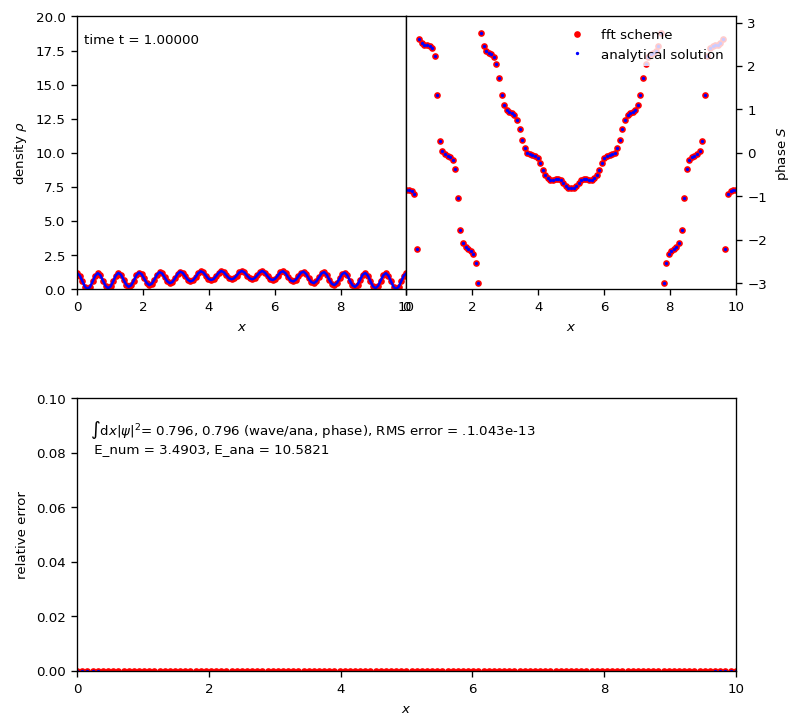

In [89]:
c = config.generateConfig()
c["t0"]             = 0.0
c["tEnd"]           = 1.0
c["resolution"]     = 129
c["boundarySize"]   = 0
c["useBC"]          = False
c["domainSize"]     = [0, 10]
c["dpi"]            = 120
c["densityYlim"]    = [0, 20]
scheme = FFTScheme(c, periodic1DGaussian) 
scheme.run()
animation.drawFrame(scheme)

#### My scheme

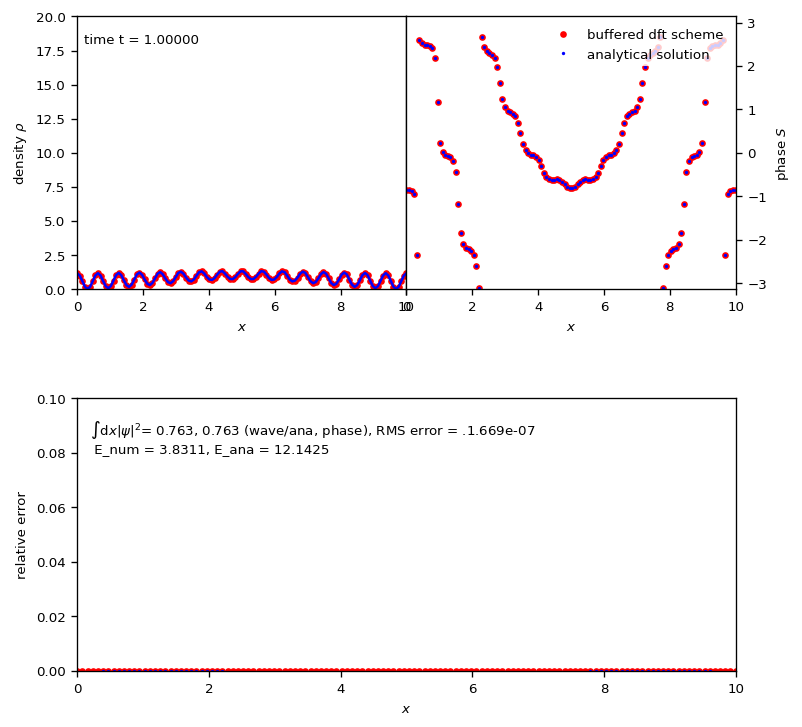

In [219]:
c = config.generateConfig()
c["t0"]                         = 0.0
c["tEnd"]                       = 1.0
c["resolution"]                 = 128
c["boundarySize"]               = 6
c["useBC"]                      = True
c["domainSize"]                 = [0, 10]
c["dpi"]                        = 120
c["densityYlim"]                = [0, 20]
c["BC"]                         = sd.PERIODIC
c["fd_lb"]                      = 0
c["fd_rb"]                      = 0
c["hom_lb"]                     = 0
c["hom_rb"]                     = 1
c["mode"]                       = sd.M_NTH_ORDER
c["derivativeMode"]             = sd.ONE_SIDED
c["derivativeOrder"]            = 0
c["smoothingOrder"]             = 10
c["smoothingIterations"]        = 0
c["smoothingMode"]              = sd.M_NTH_ORDER
c["smoothingDerivative"]        = sd.ONE_SIDED
c["smoothingDerivativeOrder"]   = 4
c["dt"]                         = 0.01*(10/128)**2 

scheme = PaddedDFTScheme(c, periodic1DGaussian) 
scheme.run()
animation.drawFrame(scheme)

#### Chebyshev

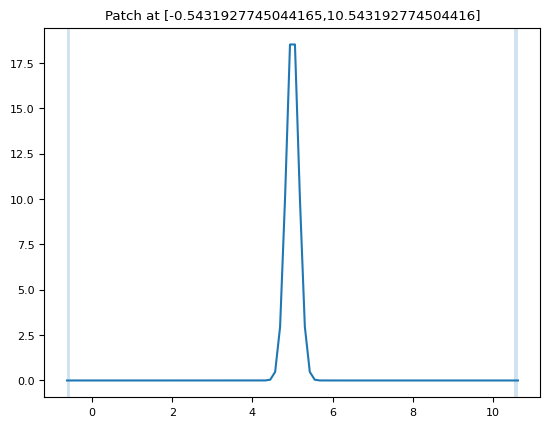

Finished in 2731 time steps


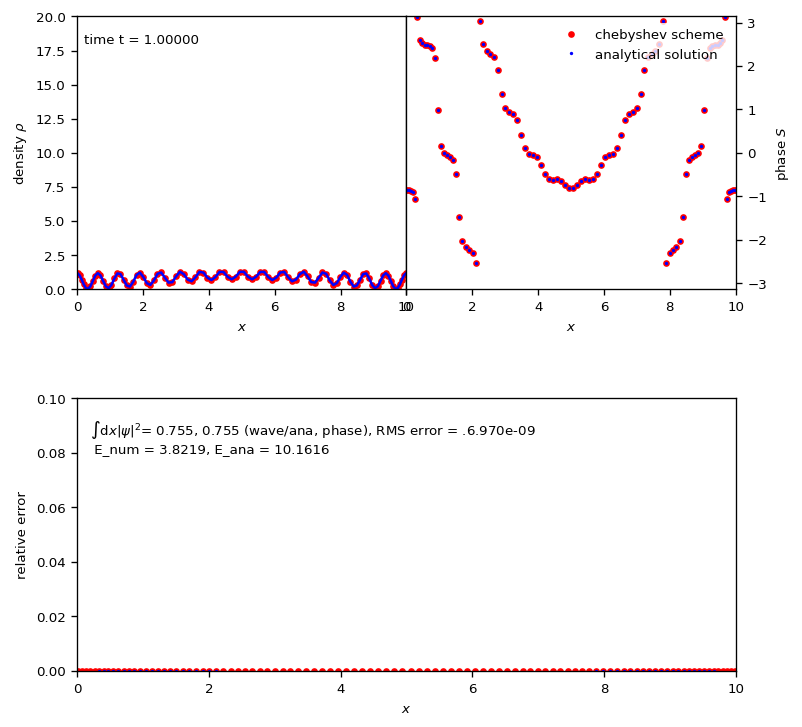

In [123]:
c = config.generateConfig()
c["t0"]                         = 0.0
c["tEnd"]                       = 1.0
c["resolution"]                 = 128
c["boundarySize"]               = 8
c["useBC"]                      = True
c["domainSize"]                 = [-0, 10]
c["dpi"]                        = 120
c["densityYlim"]                = [0, 20]
c["dt"]                         = 0.06*(10/128)**2 
scheme = ChebyshevScheme(c, periodic1DGaussian) 
scheme.run()
animation.drawFrame(scheme)

### Chebyshev multipatch

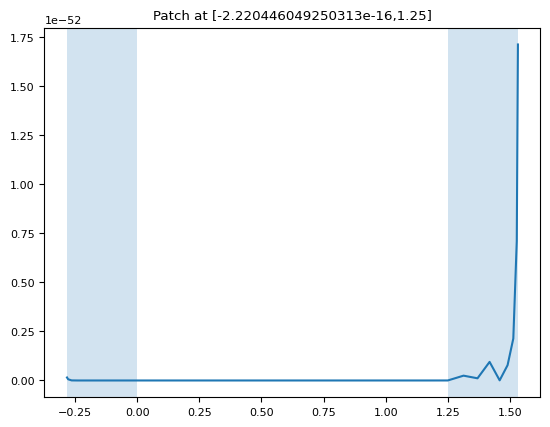

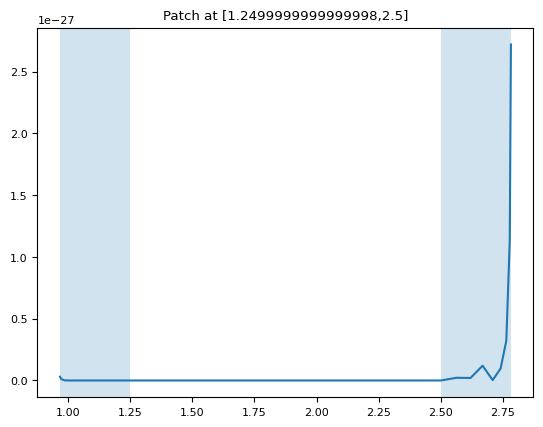

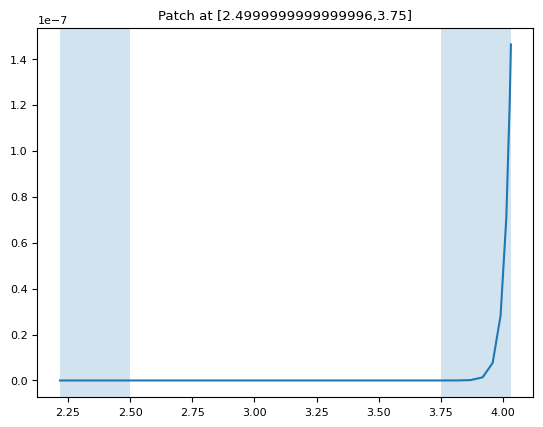

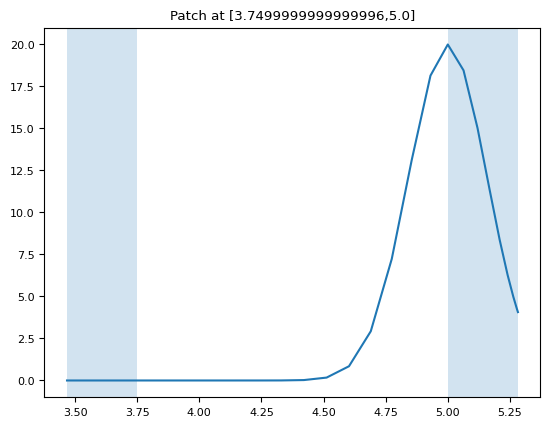

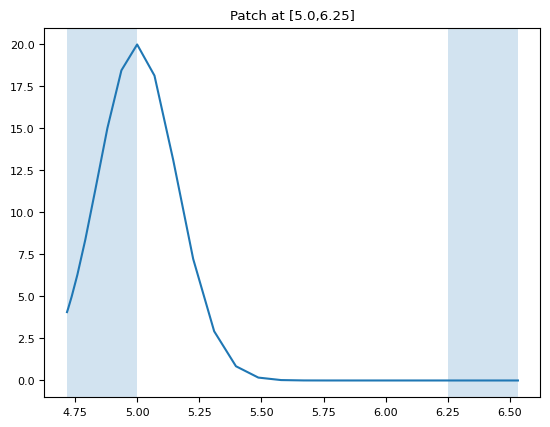

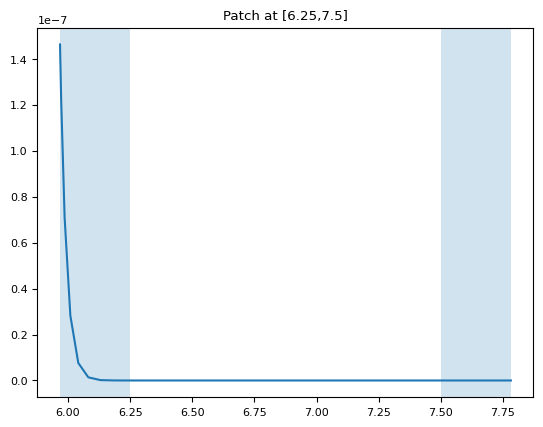

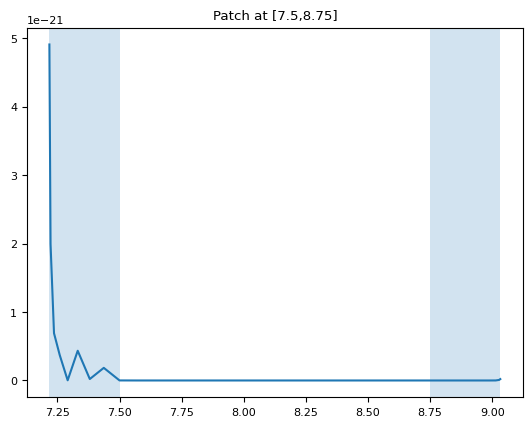

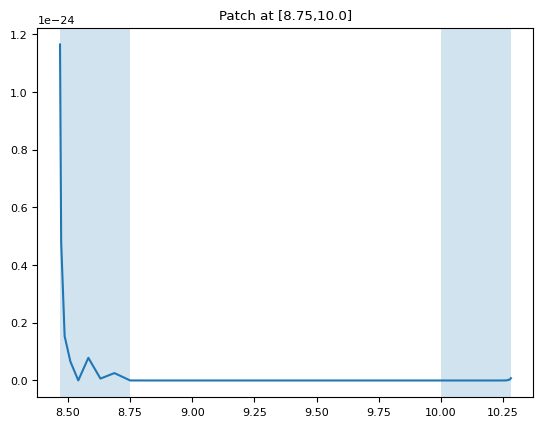

In [124]:
c = config.generateConfig()
c["t0"]                         = 0.0
c["tEnd"]                       = 1.0
c["resolution"]                 = 128
c["patchSize"]                  = 16
c["boundarySize"]               = 8
c["useBC"]                      = False
c["domainSize"]                 = [0, 10]
c["dpi"]                        = 120
c["densityYlim"]                = [0, 20]
c["dt"]                         = 0.06*(10/128)**2 
c["printGrid"]                  = False
scheme = ChebyshevSubregionScheme(c, periodic1DGaussian) 
scheme.run()
animation.drawFrame(scheme)
scheme.computeRelError(), scheme.computeRMSError()

In [122]:
0.06*(10/128)**2 / 0.004654320535981027**2 

16.905138481760137

### Test the complex absorber

Beta:  0.49  Nabs:  2
Beta:  0.49  Nabs:  3
Beta:  0.49  Nabs:  4
Beta:  0.49  Nabs:  5
Beta:  1  Nabs:  2
Beta:  1  Nabs:  3
Beta:  1  Nabs:  4
Beta:  1  Nabs:  5
Beta:  12  Nabs:  2
Beta:  12  Nabs:  3
Beta:  12  Nabs:  4
Beta:  12  Nabs:  5
Beta:  100  Nabs:  2
Beta:  100  Nabs:  3
Beta:  100  Nabs:  4
Beta:  100  Nabs:  5


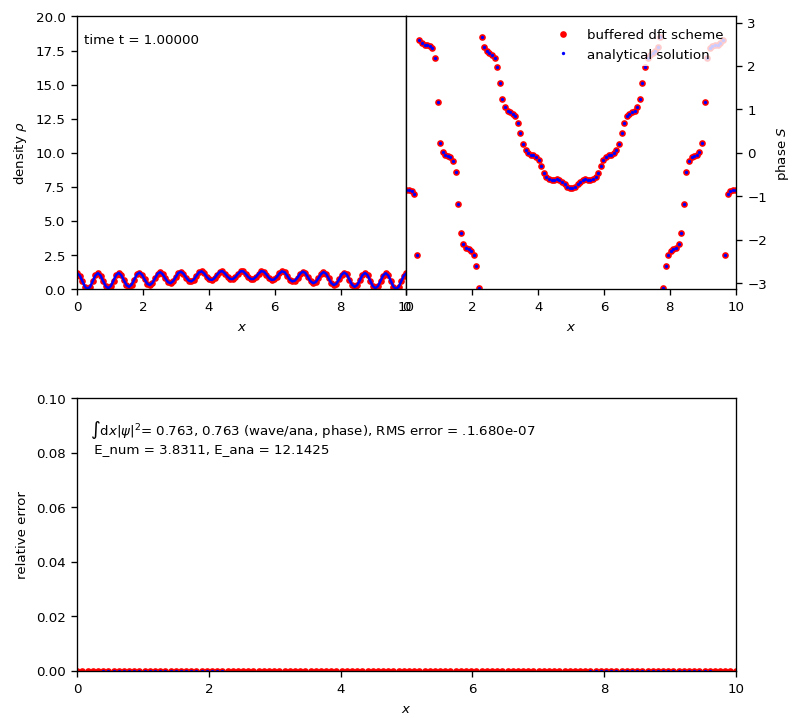

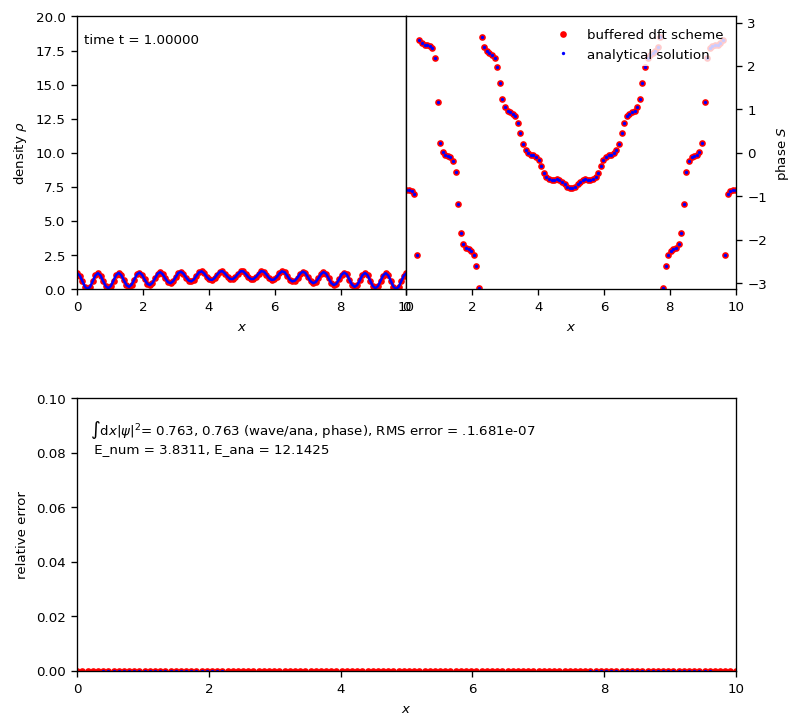

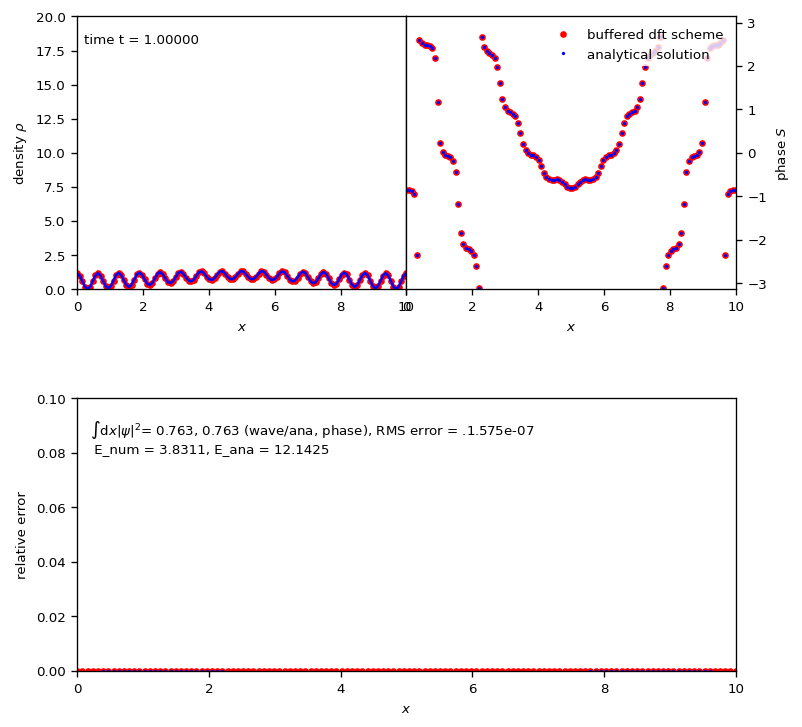

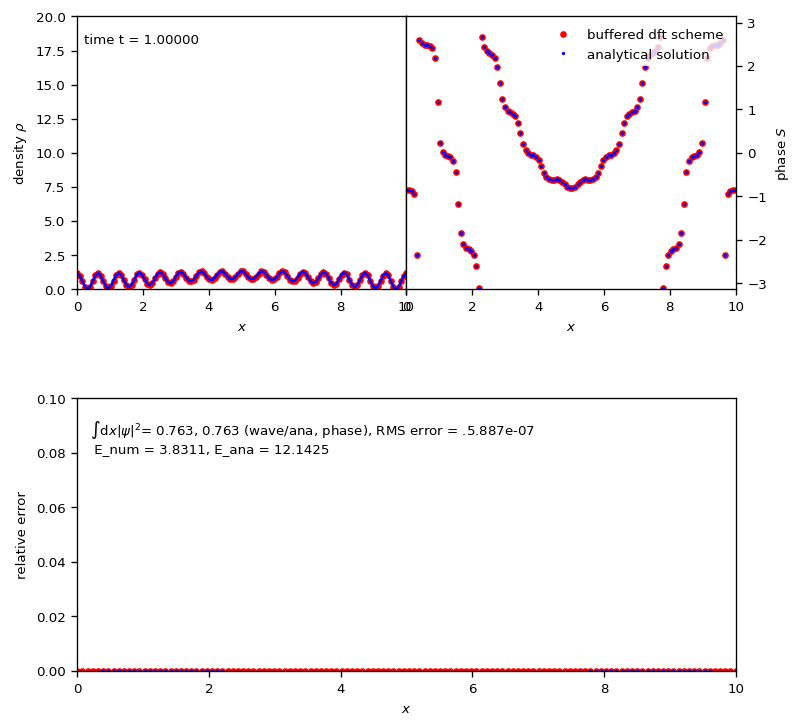

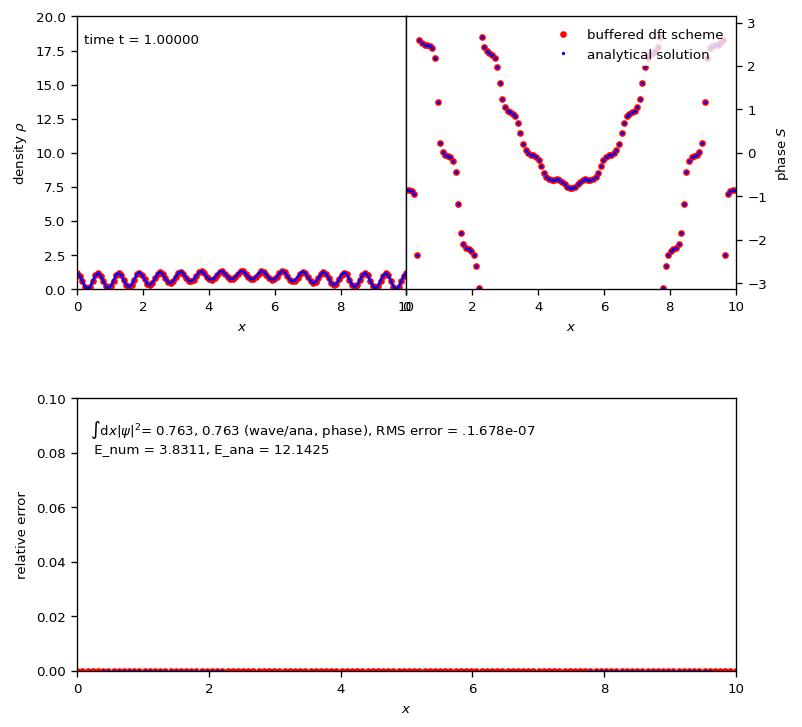

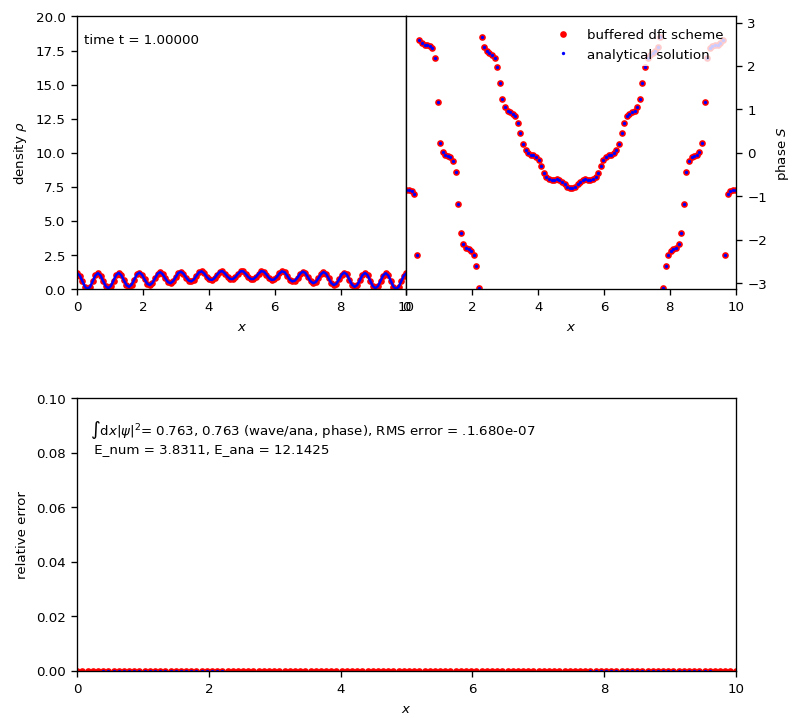

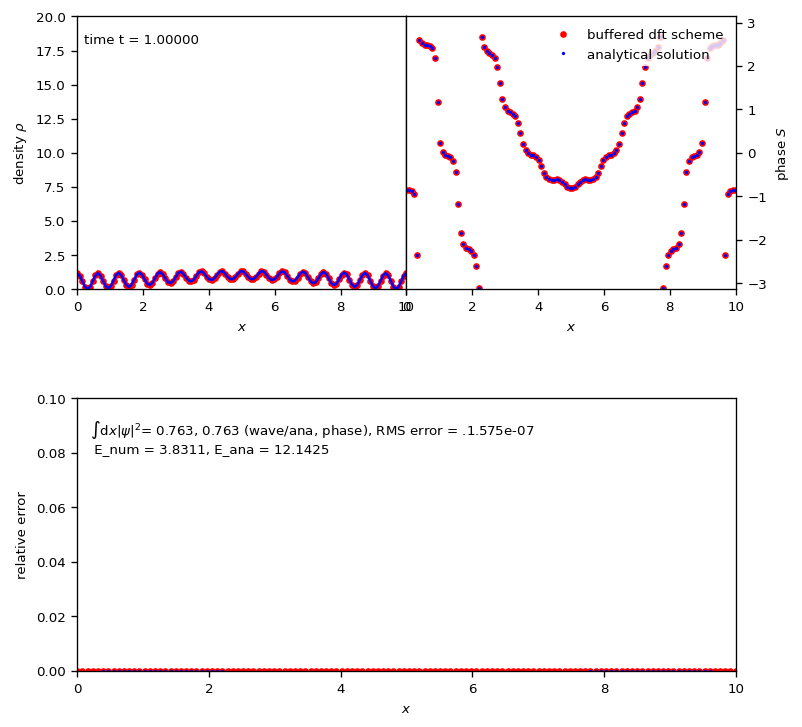

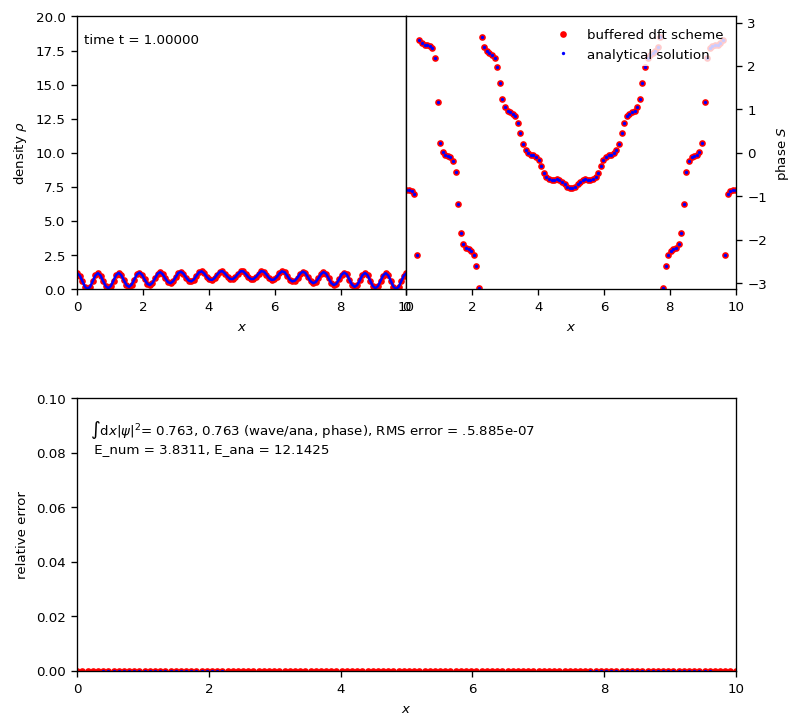

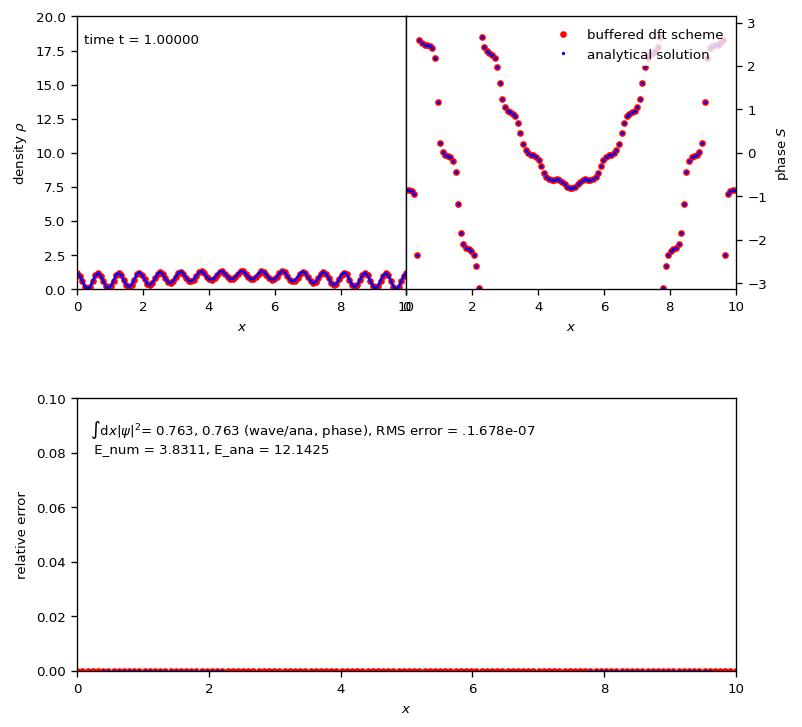

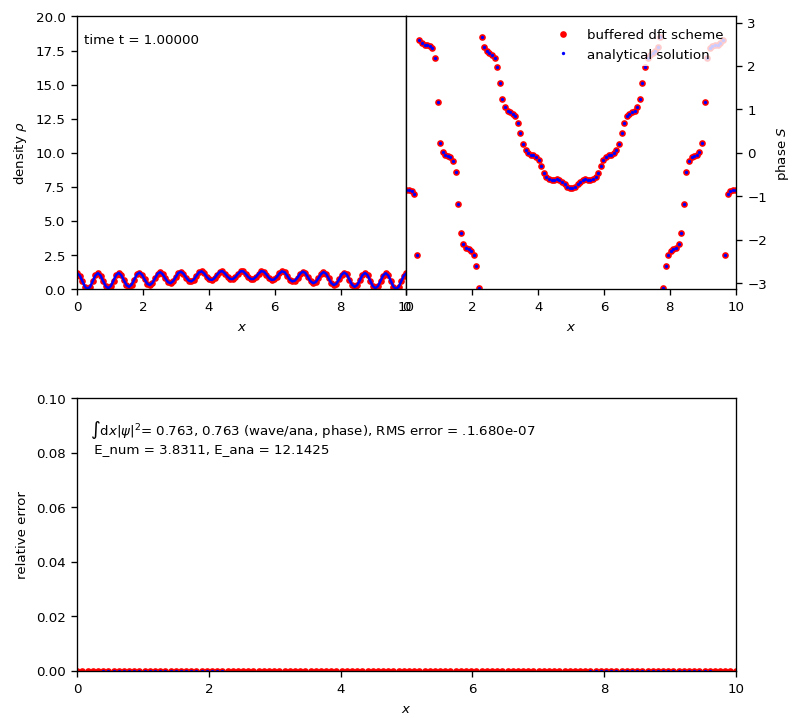

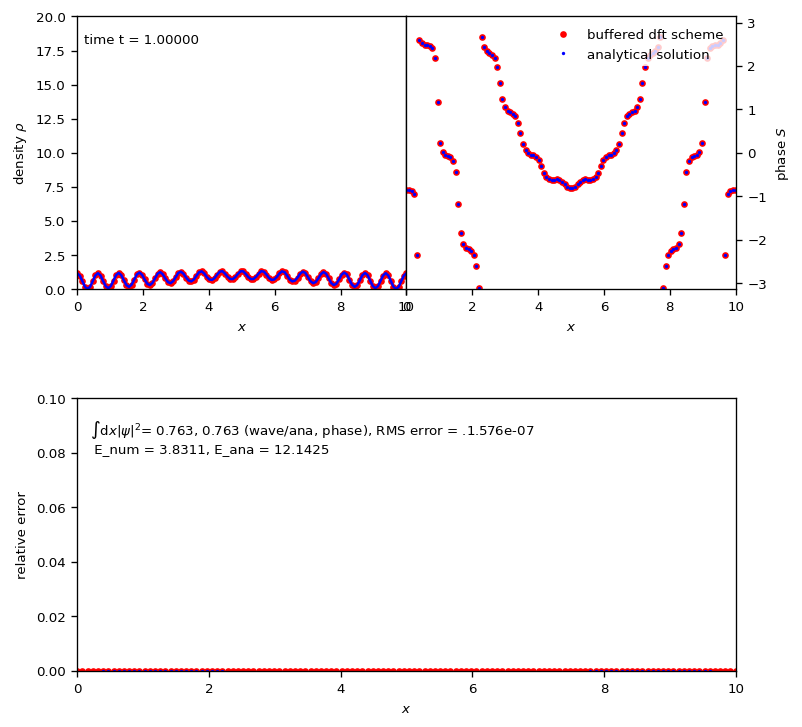

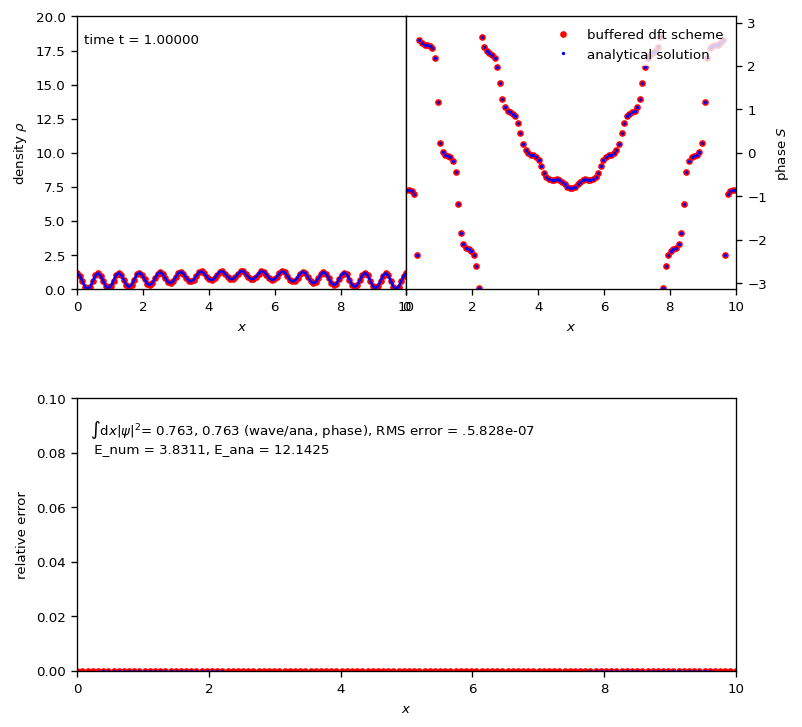

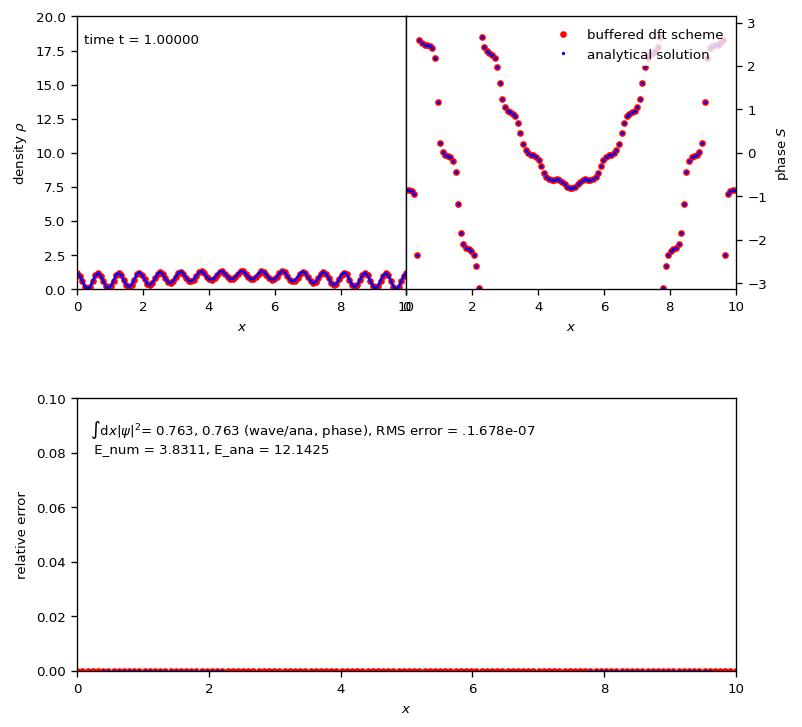

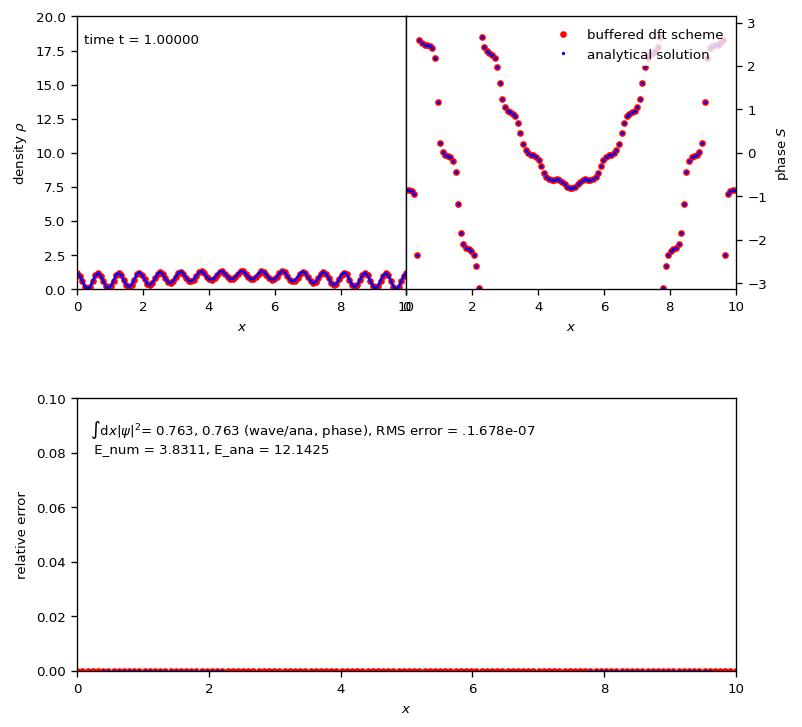

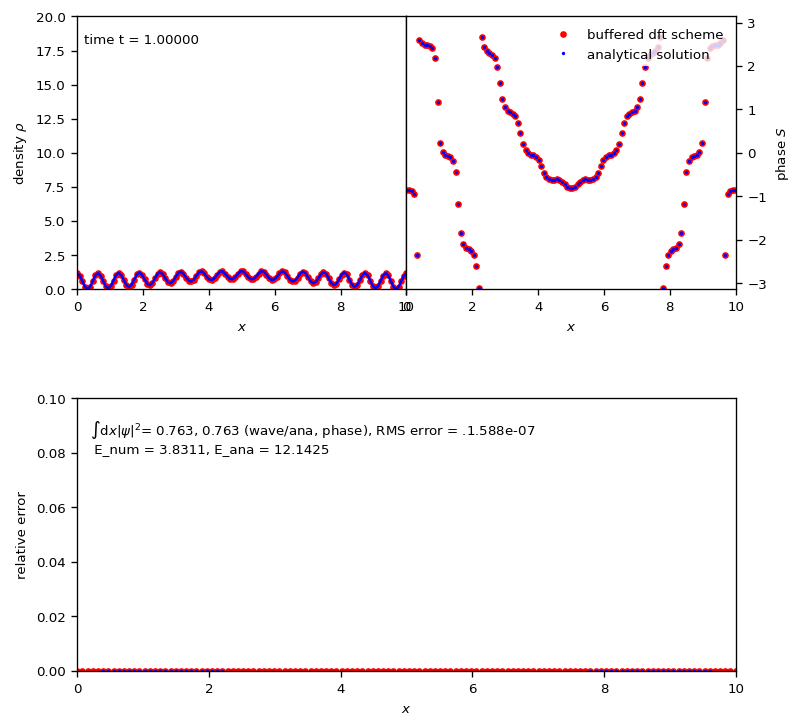

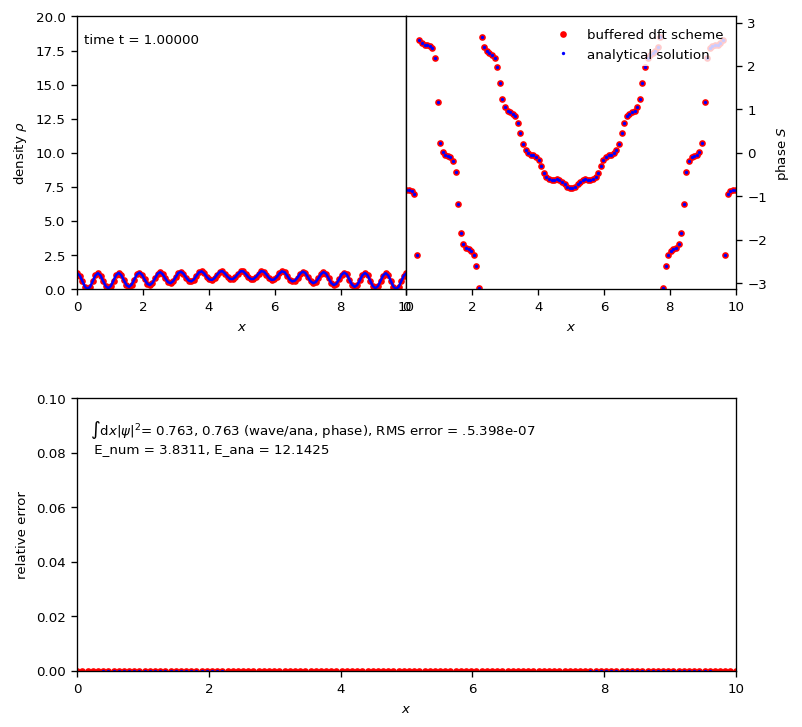

In [131]:
c = config.generateConfig()
c["t0"]                         = 0.0
c["tEnd"]                       = 1.0
c["resolution"]                 = 128
c["boundarySize"]               = 6
c["useBC"]                      = True
c["domainSize"]                 = [0, 10]
c["dpi"]                        = 120
c["densityYlim"]                = [0, 20]
c["BC"]                         = sd.PERIODIC
c["fd_lb"]                      = 0
c["fd_rb"]                      = 0
c["hom_lb"]                     = 0
c["hom_rb"]                     = 1
c["mode"]                       = sd.M_NTH_ORDER
c["derivativeMode"]             = sd.ONE_SIDED
c["derivativeOrder"]            = 0
c["smoothingOrder"]             = 10
c["smoothingIterations"]        = 0
c["smoothingMode"]              = sd.M_NTH_ORDER
c["smoothingDerivative"]        = sd.ONE_SIDED
c["smoothingDerivativeOrder"]   = 4
c["useFTransform"]              = True 
c["N_abs"]                      = 4

for beta in [0.49, 1, 12, 100]:
    for Nabs in [2, 3, 4, 5]:
        c["beta"] = beta 
        c["N_abs"] = Nabs
        print("Beta: ", beta, " Nabs: ", Nabs)
        scheme = PaddedDFTScheme(c, periodic1DGaussian) 
        scheme.run()
        animation.drawFrame(scheme)

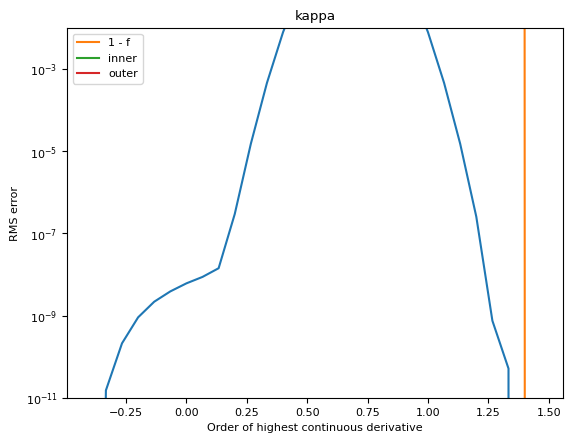

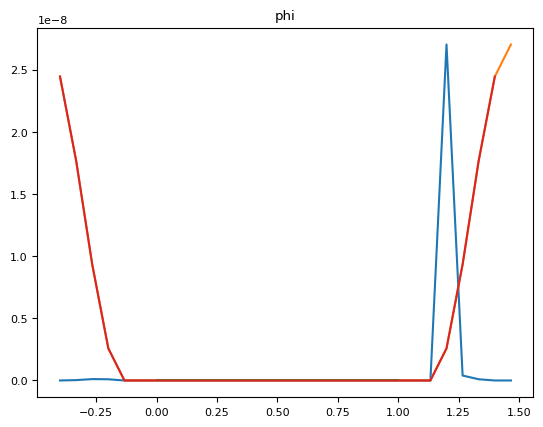

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


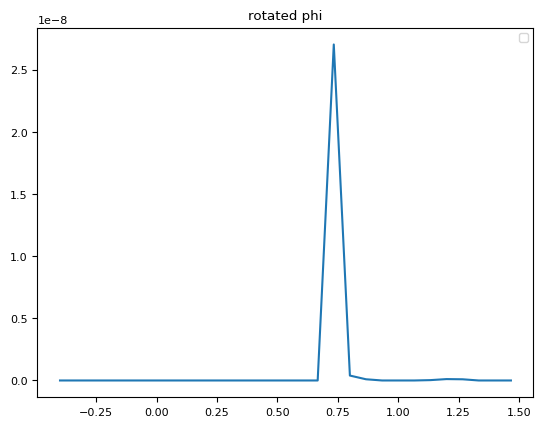

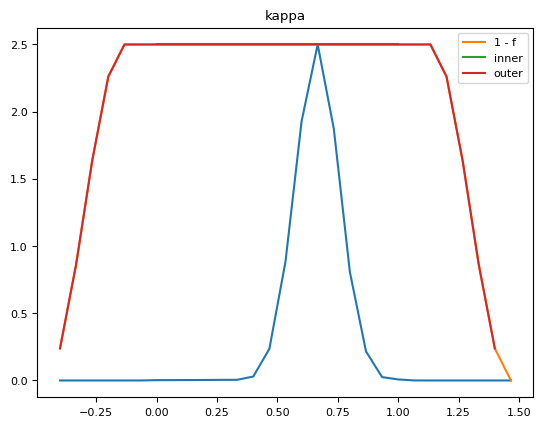

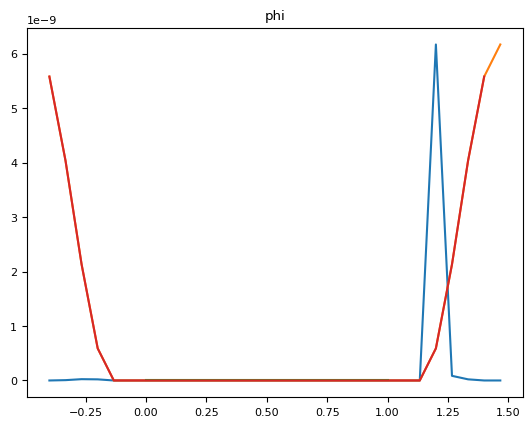

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


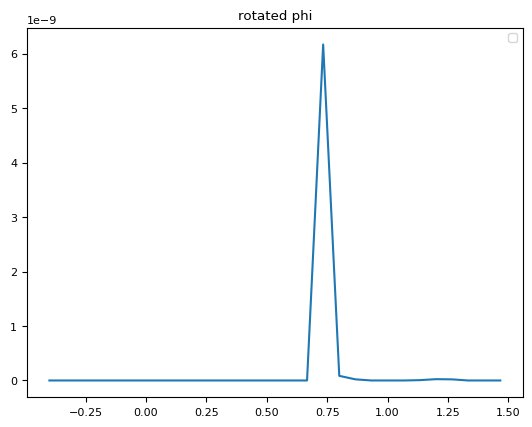

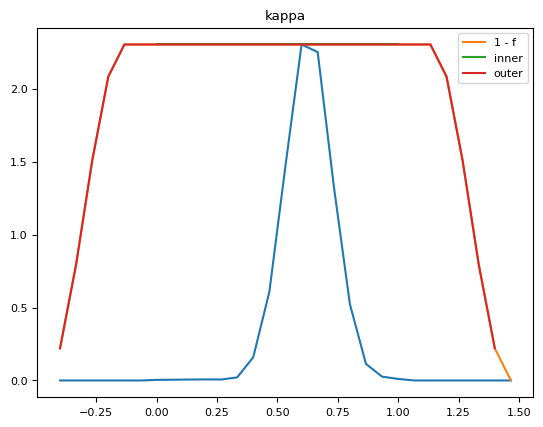

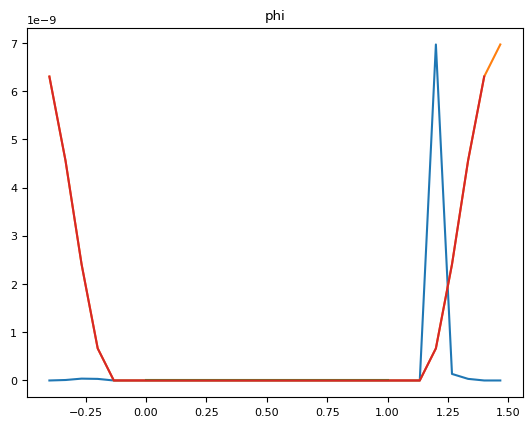

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


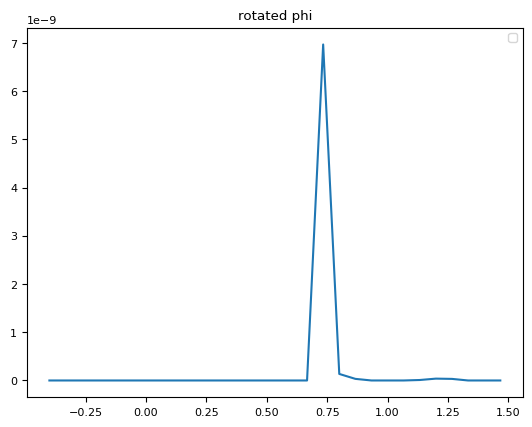

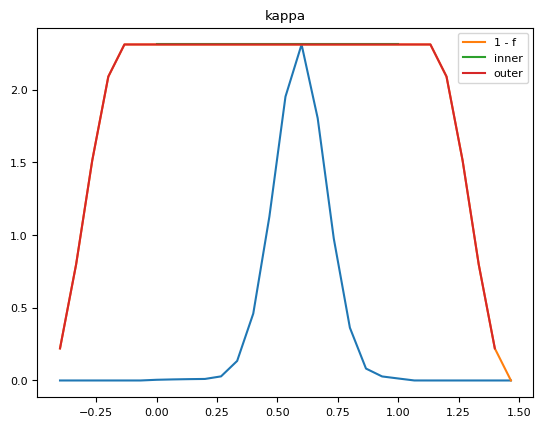

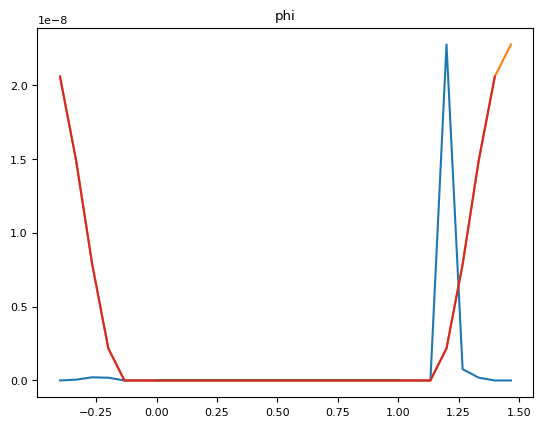

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


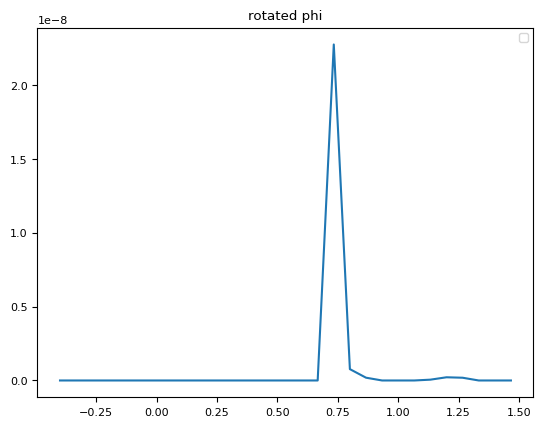

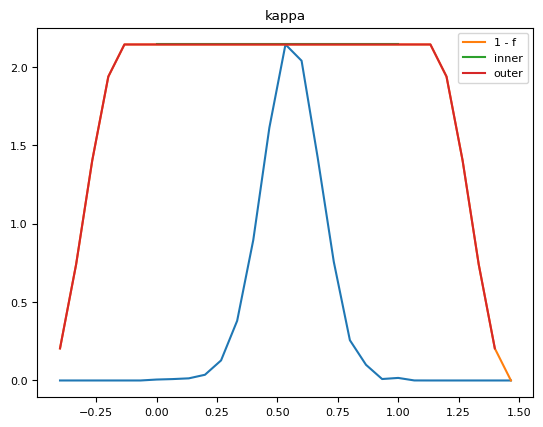

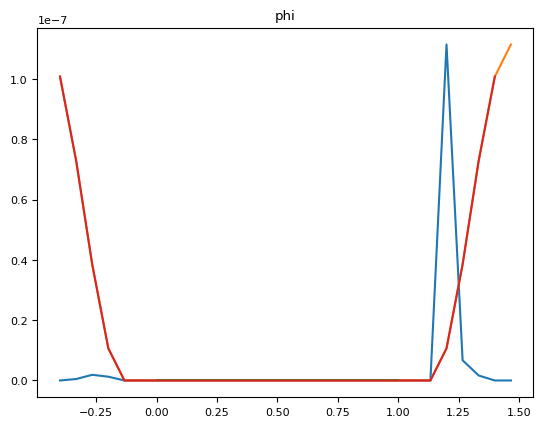

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


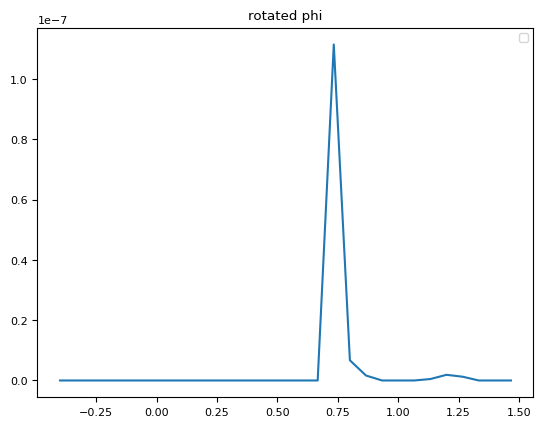

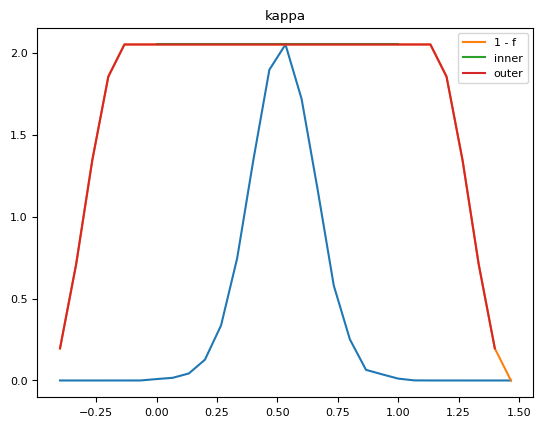

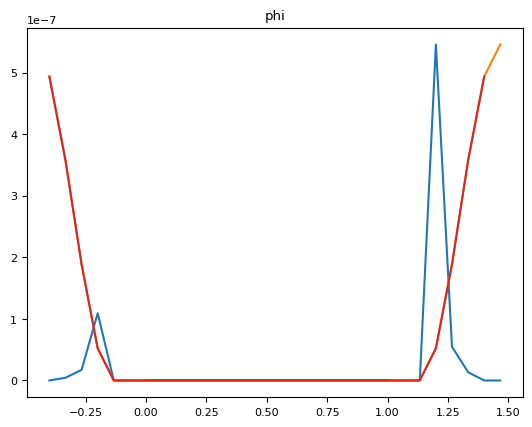

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


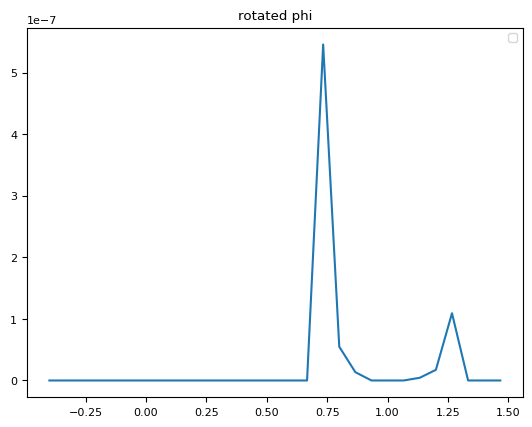

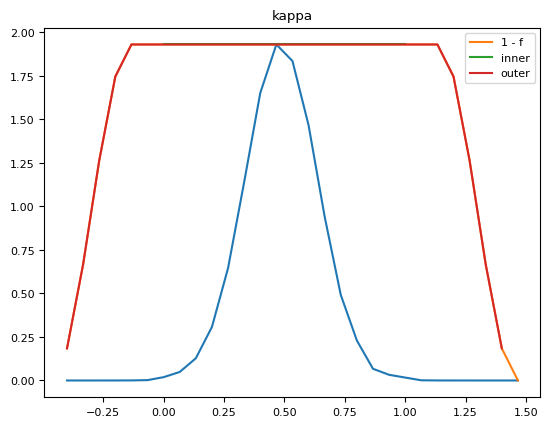

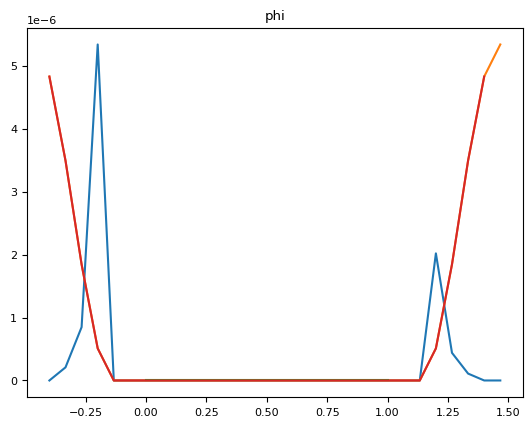

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


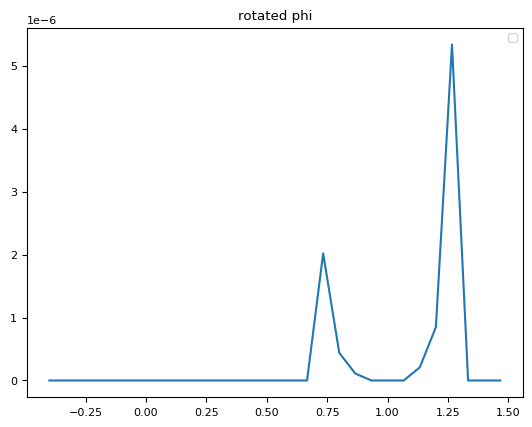

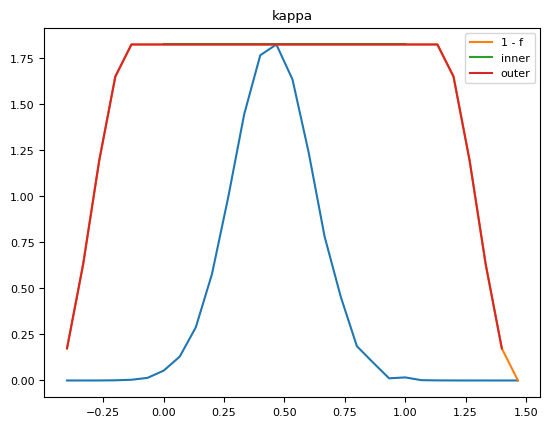

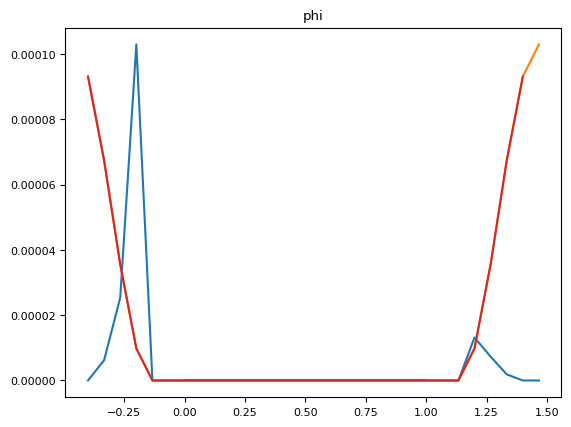

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


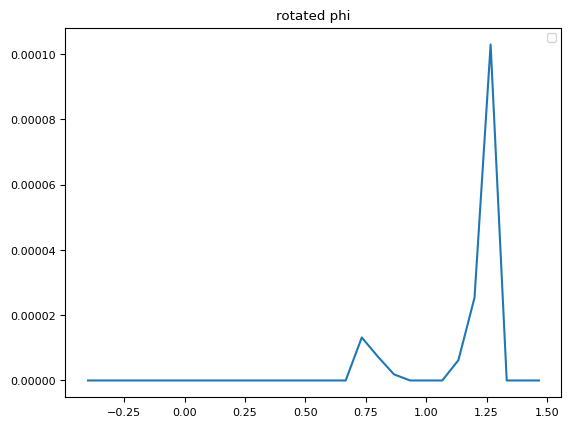

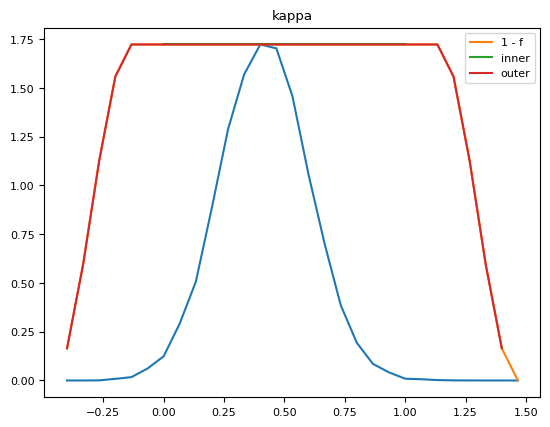

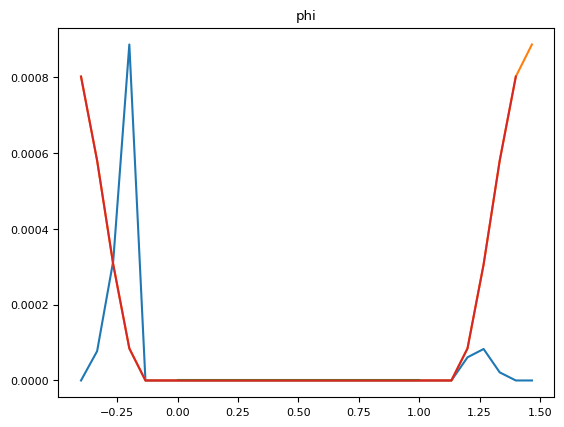

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


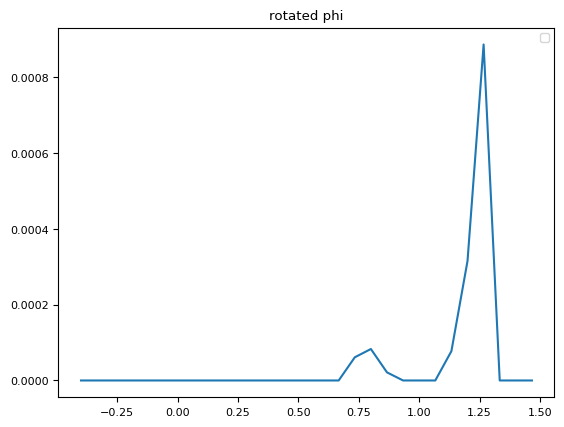

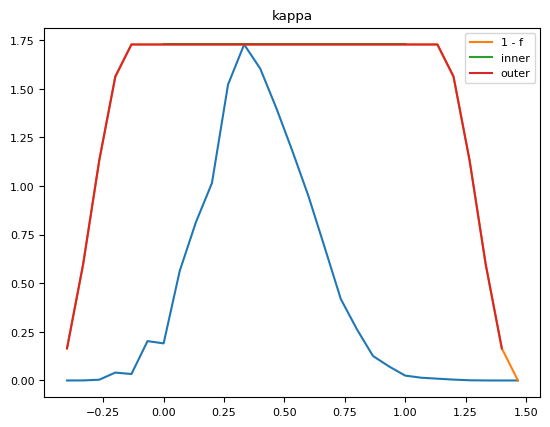

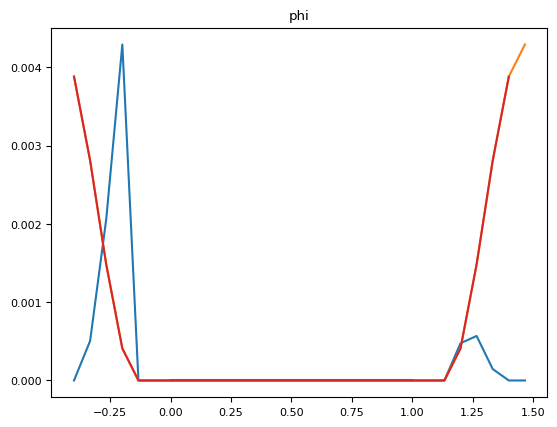

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


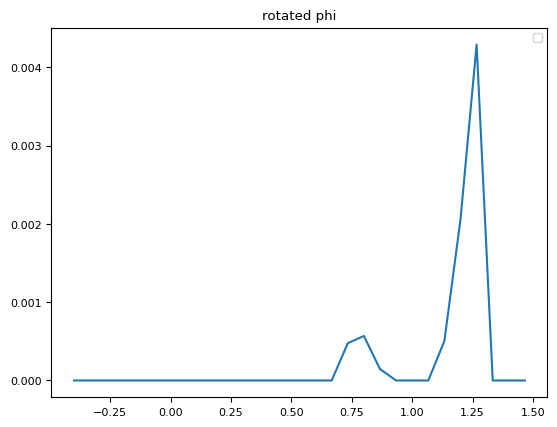

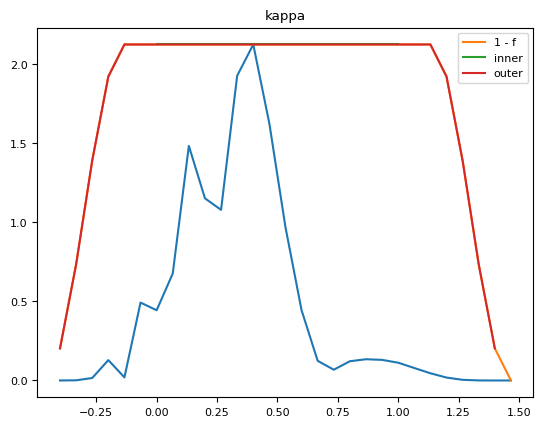

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [338]:

def extraConfig(c):
    c["nThreads"] = 4
    #c["phaseYlim"] = [-100, 100]
    c["dpi"] = 80
    c["fps"] = 20
    c["slowDown"] = 300
    c["t0"] = 0.0
    c["tEnd"] = 0.025
    c["outputTimestep"] = False
    c["stencilOrder"] = 1
    c["timeOrder"] = 1
    c["C_parabolic"] = .4
    c["C_velocity"] = 1
    c["plotDensityLogarithm"] = False
    c["densityYlim"] = [0, 10]
    c["gravity"] = 0
    c["plotDebug"] = True
    c["xlim"] = [0, 1]
    c["domainSize"] = [0, 1]
    c["usePeriodicBC"] = True
    c["sigma0"] = 1e-8
    c["useAdaptiveTimestep"] = True 
    #c["dt"] = 1e-6
    c["sigma_index"] = 4
    c["patchSize"] = 16
    c["useBC"] = True
    c["replaceBoundary"] = True
    c["printGrid"] = False

import warnings
warnings.filterwarnings('error')
c = config.generateConfig()
extraConfig(c)
#scheme = SubregionScheme( c, jowettWave, HomogeneousCosineScheme )
#scheme = DFTScheme( c, jowettWave )

c["patchSize"]  = 16
c["derivativeMode"]    = FOURTH_ORDER
c["t0"] = 0.0
c["tEnd"] = 0.025

c["sigma"] = 0
c["sigma_func"] = 5
c["dx_dist"]    = 0

c["useBC"] = True
c["unitaryUpdate"] = True

c["C_parabolic"] = .4
c["derivativeMode"]    = NTH_ORDER
c["mode"]               = MCONT_NTH_DERIVATIVE_PERIODIC
c["derivativeOrder"]   = 10
c["BC"]                 = PERIODIC
c["fd_lb"]        = 0
c["fd_rb"]        = 0
c["hom_lb"]       = 0
c["hom_rb"]       = 1
c["smoothingIterations"] = 0
c["smoothingMode"]       = MCONT_NTH_DERIVATIVE_PERIODIC
c["smoothingDerivative"] = NTH_ORDER_CENTRAL
c["smoothingDerivativeOrder"] = 4

plt.title("Error as function of resolution and smoothing order")
plt.yscale("log") 
plt.ylim(1e-11,  1e-2)
plt.xlabel("Order of highest continuous derivative") 
plt.ylabel("RMS error")
all_errors = []
for boundarySize in [6]: 
    c["boundarySize"] = boundarySize
    resolutions = 2**np.arange(4, 9)
    for resolution in resolutions:
        orders = np.arange(2, 8)
        c["resolution"] = resolution
        for dx_dist in [2, 3, 4, 5]:
            errors = []
            for smoothingOrder in orders: 
                c["derivativeOrder"] = smoothingOrder
                c["smoothingOrder"]  = smoothingOrder
                c["useFTransform"] = True 
                c["dx_dist"] = dx_dist 
                scheme = SubregionScheme( c, jowettWave, PaddedDFTScheme )
                scheme.debugWavefunction  = False 
                scheme.debugShiftfunction = False
                scheme.run() 
                #animation.drawFrame(solver = scheme, label = f"Res = {resolution} order = {order} Rel. error: {scheme.computeRelError():.3e}", analyticalSolution = jowettWave, filename = "Jowett", waveSolver = None)
                #plt.show()
                errors.append(scheme.computeRMSError())

            all_errors.append(errors)

            plt.plot(orders, errors, label=f"Dx dist: {dx_dist} Ghost: {boundarySize} N: {resolution}") 
plt.legend() 
plt.show() 

#animation.drawFrame(solver = scheme, label = f"Rel. error: {scheme.computeRelError():.3e}", analyticalSolution = jowettWave, filename = "Jowett", waveSolver = None)
#plt.show()


#c["derivativeMode"]    = FIFTH_ORDER
#c["mode"]               = MDECILINEAR_PERIODIC
#c["derivativeOrder"]   = 7
#c["BC"]                 = PERIODIC
#
#
#scheme                    = PaddedDFTScheme ( c, jowettWave )
#scheme.debugWavefunction  = False
#scheme.debugShiftfunction = False
#scheme.run()
#animation.drawFrame(solver = scheme, label = f"Rel. error: {scheme.computeRelError():.3e}", analyticalSolution = jowettWave, filename = "Jowett", waveSolver = None)
#plt.show()

### Timesteps

In [219]:

def sech(x):
    return 1 / np.cosh( x )


def spreader(x, dx, t, m = 1, hbar = 1):
    y = x
    A = 1j / ( 1j - 4 * np.tanh( 4 * t ) )
    B = - 8 * y ** 2 * sech(4 * t)**2
    C = 1j * 34 *  y ** 2 * np.tanh( 4 * t )
    D = 1 + 16 * np.tanh( 4 * t ) ** 2
    return A * np.exp((B + C) / D)



def planeWave(x, dx, t, m = 1, hbar = 1, alpha=1.0 / 10):
    return np.exp(1j * x)

def extraConfig(c):
    c["nThreads"] = 4
    c["resolution"] = 64
    #c["phaseYlim"] = [-100, 100]
    c["dpi"] = 80
    c["fps"] = 20
    c["slowDown"] = 300
    c["t0"] = 0.0
    c["tEnd"] = 0.025
    c["outputTimestep"] = False
    c["stencilOrder"] = 1
    c["timeOrder"] = 1
    c["C_parabolic"] = .4
    c["C_velocity"] = 1
    c["plotDensityLogarithm"] = False
    c["densityYlim"] = [0, 10]
    c["gravity"] = 0
    c["plotDebug"] = True
    c["xlim"] = [0, 1]
    c["domainSize"] = [0, 1]
    c["usePeriodicBC"] = True
    c["sigma0"] = 1e-8
    c["useAdaptiveTimestep"] = True 
    #c["dt"] = 1e-6
    c["sigma_index"] = 4
    c["boundarySize"] = 6
    c["patchSize"] = 16
    c["useBC"] = True
    c["replaceBoundary"] = True
    c["printGrid"] = False
    c["derivativeMode"]    = FOURTH_ORDER
    c["mode"]               = MSEPTIC_PERIODIC
    c["BC"]                 = PERIODIC
    c["fd_lb"]        = 1
    c["fd_rb"]        = 0

import warnings
warnings.filterwarnings('error')
c = config.generateConfig()
extraConfig(c)
#scheme = SubregionScheme( c, jowettWave, HomogeneousCosineScheme )
#scheme = DFTScheme( c, jowettWave )

c["patchSize"]  = 16
c["derivativeMode"]    = FOURTH_ORDER
c["t0"] = 0.0
c["tEnd"] = 0.025

c["sigma"] = 0
c["sigma_func"] = 5
c["dx_dist"]    = 0

c["resolution"] = 2
c["useBC"] = False
c["unitaryUpdate"] = False

for i in range ( 1, 2 ) :
    c["timeOrder"]  = i
    for CFL in [0.4]:
        c["C_parabolic"] = CFL
        scheme = SubregionScheme ( c, jowettWave, DFTScheme )
        scheme.run()
        animation.drawFrame(solver = scheme, label = f"Rel. error: {scheme.computeRelError():.3e}", analyticalSolution = jowettWave, filename = "Jowett", waveSolver = None)
        plt.show()


KeyboardInterrupt: 

#### High-dx test

3.92156862745098e-06 6.151480199923107e-12


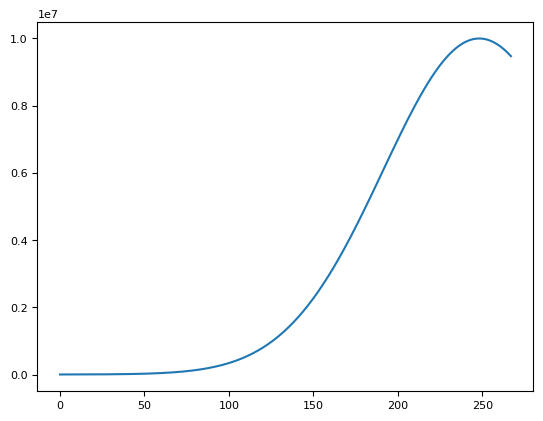

Finished in 16257 time steps


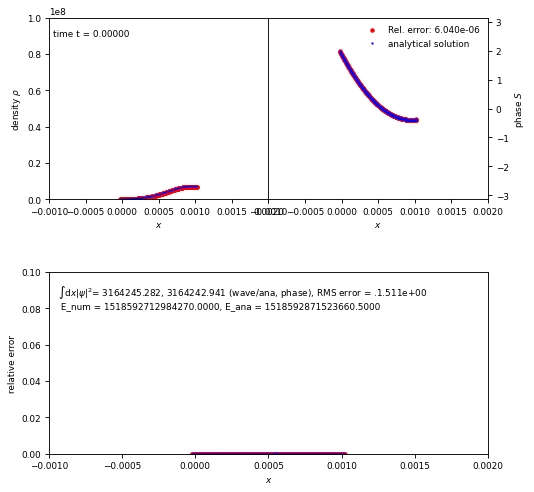

In [191]:

def sech(x):
    return 1 / np.cosh( x )


def spreader(x, dx, t, m = 1, hbar = 1):
    y = x
    A = 1j / ( 1j - 4 * np.tanh( 4 * t ) )
    B = - 8 * y ** 2 * sech(4 * t)**2
    C = 1j * 34 *  y ** 2 * np.tanh( 4 * t )
    D = 1 + 16 * np.tanh( 4 * t ) ** 2
    return A * np.exp((B + C) / D)


# Generate analytical solution for the 1D free Schrödinger equation
# Li test 1
def gaussian(x, dx, t, m = 1, hbar = 1, alpha=1e-7):
    psi = generate1DGaussian(9.5 * 1e-4, x, t, m, hbar, alpha)
    return psi


def generate1DGaussian(x0, x, t, m = 1, hbar = 1, alpha=1.0 / 10):
    psi = np.sqrt(1 / (alpha + 1.0j * t * hbar/m)) * np.exp(
        -((x - x0) ** 2) / (2 * (alpha + 1.0j * t * hbar/m))
    )
    return psi


def planeWave(x, dx, t, m = 1, hbar = 1, alpha=1.0 / 10):
    return np.exp(1j * x)

def extraConfig(c):
    c["nThreads"] = 4
    c["resolution"] = 64
    #c["phaseYlim"] = [-100, 100]
    c["dpi"] = 80
    c["fps"] = 20
    c["slowDown"] = 300
    c["t0"] = 0.0
    c["tEnd"] = 0.025
    c["outputTimestep"] = False
    c["stencilOrder"] = 1
    c["timeOrder"] = 1
    c["C_parabolic"] = .4
    c["C_velocity"] = 1
    c["plotDensityLogarithm"] = False
    c["densityYlim"] = [0, 1e8]
    c["gravity"] = 0
    c["plotDebug"] = True
    c["xlim"] = [-1e-3, 2e-3]
    c["domainSize"] = [0, 1e-3]
    c["usePeriodicBC"] = True
    c["sigma0"] = 1e-8
    c["useAdaptiveTimestep"] = True 
    #c["dt"] = 1e-6
    c["sigma_index"] = 4
    c["boundarySize"] = 6
    c["patchSize"] = 16
    c["useBC"] = True
    c["replaceBoundary"] = True
    c["printGrid"] = False
    c["derivativeMode"]    = FOURTH_ORDER
    c["mode"]               = MSEPTIC_PERIODIC
    c["BC"]                 = PERIODIC
    c["fd_lb"]        = 1
    c["fd_rb"]        = 0

import warnings
warnings.filterwarnings('error')
c = config.generateConfig()
extraConfig(c)
#scheme = SubregionScheme( c, jowettWave, HomogeneousCosineScheme )
#scheme = DFTScheme( c, jowettWave )

c["patchSize"]  = 16
c["derivativeMode"]    = FOURTH_ORDER
c["t0"] = 0.0
c["tEnd"] = 1e-7#1e-7#0.025 * 1e-4

c["sigma"] = 0
c["sigma_func"] = 5
c["dx_dist"]    = 0

c["resolution"] = 256
c["useBC"] = False
c["unitaryUpdate"] = False

for i in range ( 2, 3 ) :
    c["timeOrder"]  = i
    for CFL in [0.4]:
        c["C_parabolic"] = CFL
        scheme = SubregionScheme ( c, gaussian, DFTScheme )
        print(scheme.dx, scheme.getTimeStep())
        plt.plot(np.abs(scheme.psi)**2)
        plt.show()
        #scheme = DFTScheme( c, jowettWave)
        scheme.run()
        animation.drawFrame(solver = scheme, label = f"Rel. error: {scheme.computeRelError():.3e}", analyticalSolution = gaussian, filename = "Jowett", waveSolver = None)
        plt.show()


#### Where does instability in subregion scheme come from?

##### Unstable configuration
    - JowettWave at resolution of 256 from 0, 1 suddenly declines in subregion scheme for CFL = 0.4

#### Dependence on timestep?
    - Clearly existing: CFL = 0.4 unstable, CFL = 0.2 stable here, CFL = 0.1 gives even smaller error
    - Error also drops drastically with the size of the timestep
    - Should we check dx^3 scaling?

### Absorber width

Ref = 6.87086e-07


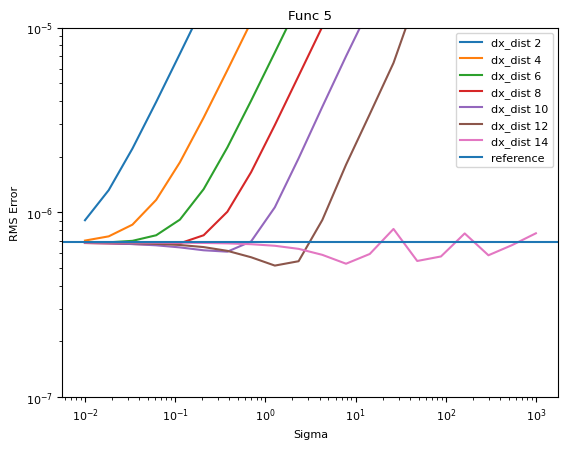

5.149682580212524e-07


In [257]:
warnings.filterwarnings('ignore')

def extraConfig(c):
    c["nThreads"] = 4
    c["resolution"] = 64
    #c["phaseYlim"] = [-100, 100]
    c["dpi"] = 80
    c["fps"] = 20
    c["slowDown"] = 300
    c["t0"] = 0.0
    c["tEnd"] = 0.025
    c["outputTimestep"] = False
    c["stencilOrder"] = 1
    c["timeOrder"] = 1
    c["C_parabolic"] = .4
    c["C_velocity"] = 1
    c["plotDensityLogarithm"] = False
    c["densityYlim"] = [0, 10]
    c["gravity"] = 0
    c["plotDebug"] = True
    c["xlim"] = [-0.25, 1.25]
    c["domainSize"] = [0, 1]
    c["usePeriodicBC"] = True
    c["sigma0"] = 1e-8
    c["useAdaptiveTimestep"] = True 
    #c["dt"] = 1e-6
    c["sigma_index"] = 4
    c["boundarySize"] = 6
    c["patchSize"] = 16
    c["useBC"] = True
    c["replaceBoundary"] = True
    c["printGrid"] = False
    c["derivativeMode"]    = FIFTH_ORDER
    c["mode"]               = MNONIC_PERIODIC
    c["BC"]                 = PERIODIC
    c["fd_lb"]        = 1
    c["fd_rb"]        = 0
import warnings
warnings.filterwarnings("ignore")
c = config.generateConfig()
extraConfig(c)
#scheme = SubregionScheme( c, jowettWave, HomogeneousCosineScheme )
#scheme = DFTScheme( c, jowettWave )

c["resolution"] = 64
c["patchSize"]  = 16
c["derivativeMode"]    = FIFTH_ORDER
c["t0"] = 0.0
c["tEnd"] = 0.025
c["boundarySize"] = 16 
c["sigma"] = 0
c["sigma_func"] = 0
c["dx_dist"]    = 0
scheme = SubregionScheme( c, jowettWave, DFTScheme)
scheme.run()
current_min = scheme.computeRMSError()
current_ref = scheme.computeRMSError()
print(f"Ref = {current_min:.5e}")

errors = []

for sigma_func in [5]:

    plt.title(f"Func {sigma_func}") 

    for dx_dist in [2, 4, 6, 8, 10, 12, 14]: 
        cur_error = []
        sigmas =  np.logspace(-2, 3, 20)
        for sigma in sigmas: 
            c["sigma"]      = sigma
            c["sigma_func"] = sigma_func
            c["dx_dist"]    = dx_dist 

            scheme = SubregionScheme( c, jowettWave, DFTScheme)
            scheme.run()
            errors.append(scheme.computeRMSError())
            if errors[-1] < current_ref * 0.5:
                print(f"Sigma = {sigma} sigma_func = {sigma_func} dx_dist = {dx_dist} error = {errors[-1]:.5e}")
            #animation.drawFrame(solver = scheme, label = "GAMER subregion", analyticalSolution = jowettWave, filename = "Jowett", waveSolver = None)
            #plt.show()
            cur_error.append(errors[-1])

        plt.loglog(sigmas, cur_error, label=f"dx_dist {dx_dist}")
    plt.axhline(current_ref, label="reference")
    plt.xlabel("Sigma") 
    plt.ylabel("RMS Error") 
    plt.ylim([1e-7, 1e-5])
    plt.legend()
    plt.show()

print(np.min(errors))

### Leapfrog

Finished in 13108 time steps
Finished in 131 time steps


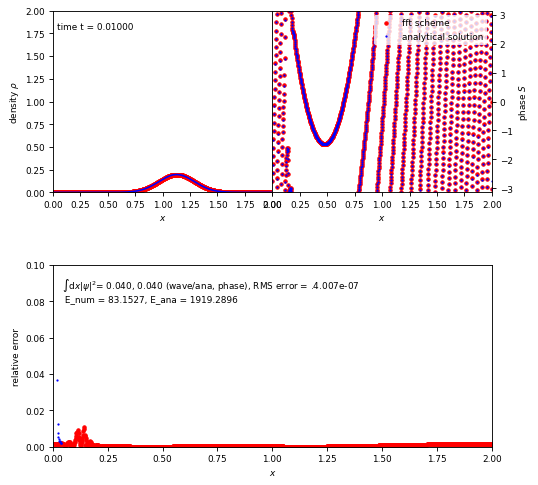

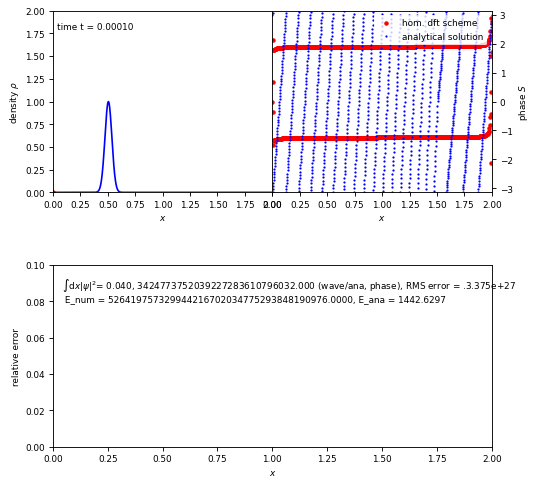

In [64]:

class FFTScheme(Scheme):
    def __init__(self, config, generateIC):
        super().__init__(config, generateIC)

        self.BC              = PERIODIC      
        self.fd_lb           = 0
        self.fd_rb           = 0


    def step(self, dt):
        #Aliases
        x           = self.grid[0]
        psi         = self.psi
        dx          = self.dx
        BC          = self.BC 
        fd_lb       = self.fd_lb
        fd_rb       = self.fd_rb
        N           = len(psi)
        
        
        #REGULAR SPECTRAL 

        if 0: 
                p, ind1, ind2   = selectBC(self.psi, self.BC)
                k = computeK(p, dx, self.BC) 
                psihat = scipy.fft.fftn(p)
                psihat = np.exp(dt * (-1.0j * self.eta * k**2 / 2.0)) * psihat
                self.psi[ind1:ind2] = scipy.fft.ifftn(psihat)
#

        elif 1: 
                #LEAPFROG
                p, ind1, ind2   = selectBC(self.psi, self.BC)
                ddpsi, k        = laplacianDtt1D(p, dx, self.BC)
        ###
                psi_buf = np.copy(self.psi)
        ###
                self.psi[ind1:ind2] = self.old_fields[ind1:ind2] + dt  * 1j * self.eta * ddpsi 
        ###
                self.old_fields = psi_buf

        #LEAPFROG SPECTRAL

        #psi_buf = np.copy(self.psi)
##
        #p, ind1, ind2       = selectBC(self.psi, self.BC)
        #k                   = computeK(p, dx, self.BC) 
        #psihat              = scipy.fft.fftn(p)
        #psihat              = np.exp(dt * (-1.0j * self.eta * k**2)) * psihat
        #psiupdate           = scipy.fft.ifftn(psihat)
    #
        #ddpsi               = psiupdate - p
        #self.psi[ind1:ind2] = self.old_fields[ind1:ind2] + ddpsi 
##
        #self.old_fields = psi_buf
        self.t += dt


    def getName(self):
        return "fft scheme"
    


def planeWave(x, dx, t, m = 1, hbar = 1, alpha=1.0 / 10):
    return np.exp(1j * x * 2*np.pi)

def extraConfig(c):
    c["nThreads"] = 4
    c["resolution"] = 64
    #c["phaseYlim"] = [-100, 100]
    c["dpi"] = 80
    c["fps"] = 20
    c["slowDown"] = 300
    c["t0"] = 0.0
    c["tEnd"] = 0.025
    c["outputTimestep"] = False
    c["stencilOrder"] = 1
    c["C_parabolic"] = .2
    c["C_velocity"] = 1
    c["plotDensityLogarithm"] = False
    c["densityYlim"] = [0,2]
    c["gravity"] = 0
    c["plotDebug"] = True
    c["xlim"] = [0, 2]
    c["domainSize"] = [0, 2]
    c["usePeriodicBC"] = True
    c["useAdaptiveTimestep"] = True 
    #c["dt"] = 1e-6
    c["boundarySize"] = 0
    c["patchSize"] = 16
    c["useBC"] = True

import warnings
warnings.filterwarnings('error')
c = config.generateConfig()
extraConfig(c)
c["t0"] = 0.0
c["resolution"] = 1025
scheme = FFTScheme(c, periodicTravellingWavePacket) 

scheme.run(0.01)

animation.drawFrame(scheme)

c["resolution"] = 1024
c["derivativeMode"]    = FOURTH_ORDER
c["mode"]               = MQUINTIC_PERIODIC
c["BC"]                 = PERIODIC
c["fd_lb"]              = 1
c["fd_rb"]              = 0
c["sigma"]              = 0
c["sigma_func"]         = 0
c["dx_dist"]            = 0

scheme = LeapfrogDFTScheme(c, periodicTravellingWavePacket) 

scheme.run(0.0001)

animation.drawFrame(scheme)

### Accuracy tests

Finished in 1 time steps
32 0.1478064684787889 0.09966120367751875
Finished in 3 time steps
64 0.08624922120054739 0.03021562603732209
Finished in 11 time steps


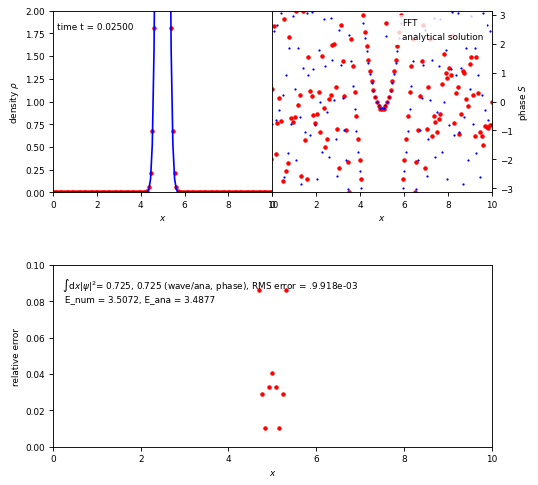

128 0.04050922890998806 0.009918450892138365
Finished in 1 time steps
32 0.011964882541408428 0.006264500944927513
Finished in 3 time steps
64 0.007538151698589041 0.003579011462450922
Finished in 11 time steps


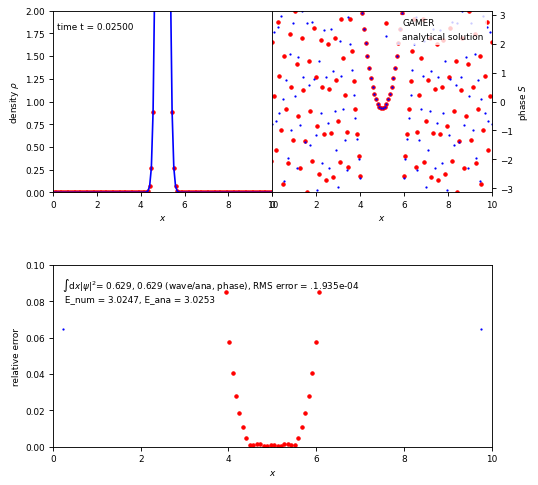

128 0.0007822597099280467 0.00019348404041804817
32 0.019620566172887984 0.010781499372303162
64 3.6686522925327074e-06 1.6638889978210115e-06


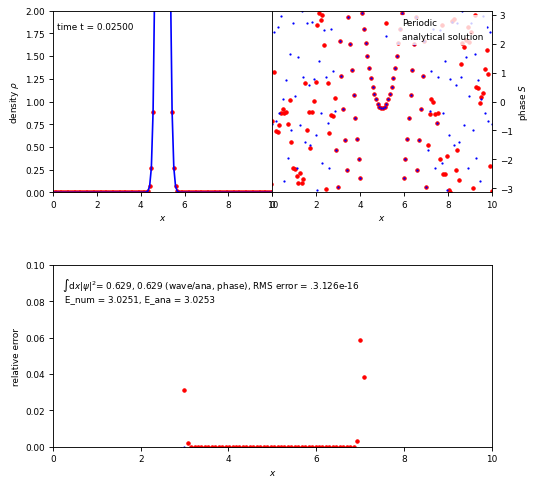

128 1.4251277071986512e-15 3.1260678313960685e-16
32 0.019565264061953323 0.010781176415344929
64 3.6687479830523054e-06 1.660301429082286e-06


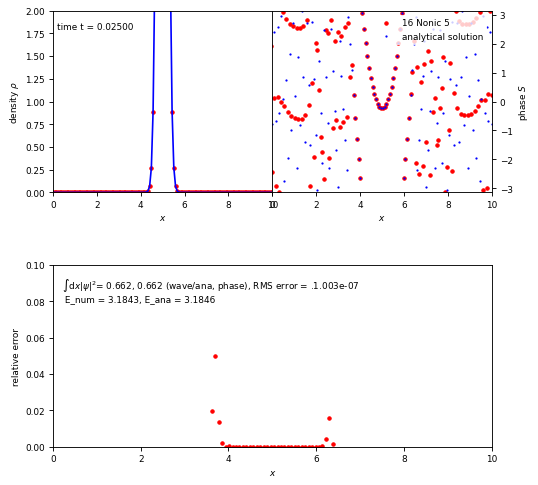

128 5.005801396541686e-07 1.0025679339205036e-07
32 0.019565264060530337 0.010781176415341827
64 3.669021630110544e-06 1.6601420720756387e-06


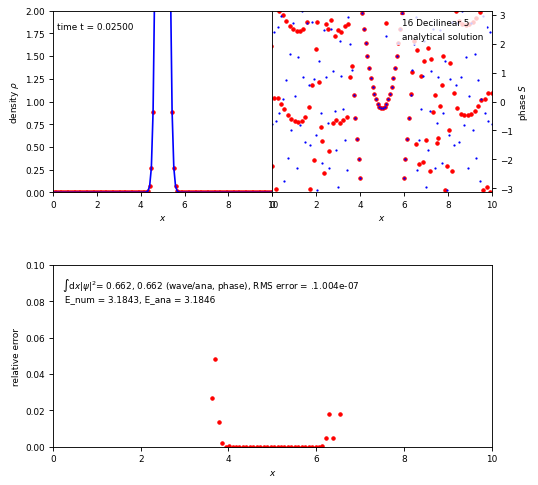

128 5.075386513262471e-07 1.003905771213391e-07
32 0.019564915148950295 0.010780963347116344
64 0.0005825868695148583 0.00017590216315899223


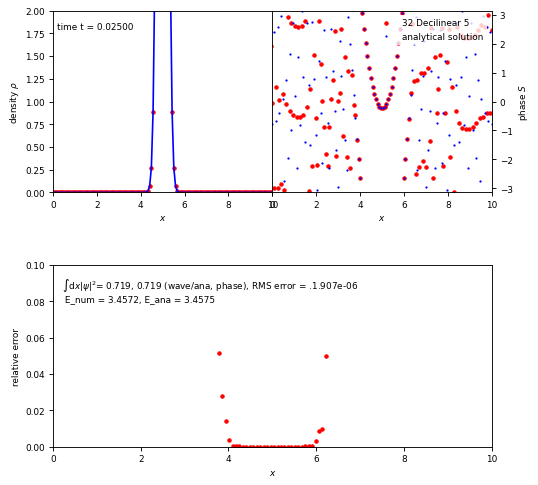

128 1.1382400327994335e-05 1.9069477893362697e-06


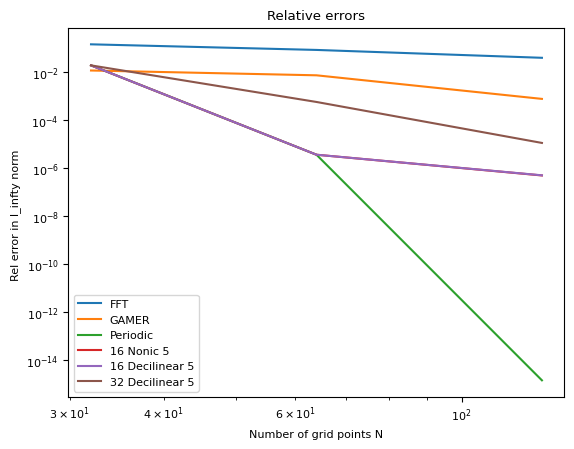

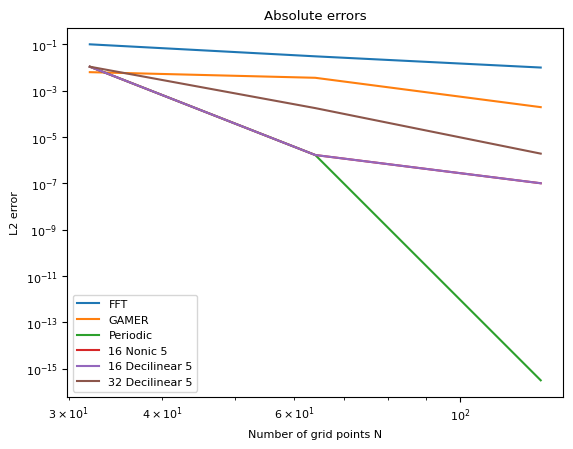

In [275]:
def extraConfig(c):
    c["resolution"] = 32
    c["t0"] =  0.00
    c["tEnd"] = 0.025
    c["dpi"] = 80
    c["outputTimestep"] = False
    c["stencilOrder"] = 3
    c["timeOrder"] = 2
    c["C_parabolic"] = .4
    c["C_velocity"] = 1
    c["plotDensityLogarithm"] = False
    c["densityYlim"] = [0, 2]
    c["gravity"] = 0
    c["plotDebug"] = True
    c["xlim"] = [0, 10]
    c["domainSize"] = [0, 10]
    c["usePeriodicBC"] = False
    c["useBC"] = True
    c["boundarySize"] = 16
    c["useAdaptiveTimestep"] = True 
    c["patchSize"] = 32
    c["printGrid"] = False
    c["replaceBoundary"] = True 

def setSine(c_org):
    c = dict(c_org)
    c["derivativeMode"]               = sd.FOURTH_ORDER
    c["mode"]    = MLINEAR
    c["BC"]                 = DD
    c["fd_lb"]              = 0
    c["fd_rb"]              = 0
    return c

def setCosine(c_org):
    c = dict(c_org)
    c["derivativeMode"]    = FOURTH_ORDER
    c["mode"]               = MCUBIC_NN
    c["BC"]                 = NN
    c["fd_lb"]              = 0
    c["fd_rb"]              = 0
    return c

def setPeriodic(c_org):
    c = dict(c_org)
    c["derivativeMode"]    = FIFTH_ORDER
    c["mode"]               = MNONIC_PERIODIC
    c["BC"]                 = PERIODIC
    c["fd_lb"]              = 1
    c["fd_rb"]              = 0
    return c


def setDecilinear(c_org):
    c = dict(c_org)
    c["derivativeMode"]    = FIFTH_ORDER
    c["mode"]               = MDECILINEAR_PERIODIC
    return c

def setNonic(c_org):
    c = dict(c_org)
    c["mode"]           = MNONIC_PERIODIC
    return c


def setSeptic(c_org):
    c = dict(c_org)
    c["mode"]           = MSEPTIC_PERIODIC
    return c

def setQuintic(c_org):
    c = dict(c_org)
    c["mode"]           = MQUINTIC_PERIODIC
    return c


def setCentral(c_org):
    c = dict(c_org)
    c["fd_lb"]           = 3
    c["fd_rb"]           = 2
    c["derivativeMode"] = FOURTH_ORDER_CENTRAL
    return c

def setThird(c_org):
    c = dict(c_org)
    c["derivativeMode"] = THIRD_ORDER
    return c

def setConsistent(c_org):
    c = dict(c_org)
    c["derivativeMode"] = CONSISTENT
    return c

def setPotential(c_org): 
    c = dict(c_org)
    c["sigma"] = 20
    c["sigma_func"] = 5
    c["dx_dist"]    = 3
    return c

c = config.generateConfig()
extraConfig(c)

#Homogeneous cosine scheme
cfull = dict(c)
cfull["useBC"] = True

c8 = dict(c)
c8["useBC"] = False
c8["timeOrder"] = 1
c8["patchSize"] = 8
c8["boundarySize"] = 6

c16 = dict(c)
c16["useBC"] = False
c16["timeOrder"] = 1
c16["patchSize"] = 32
c16["boundarySize"] = 12

c32 = dict(c)
c32["useBC"] = False
c32["timeOrder"] = 1
c32["patchSize"] = 32
c32["boundarySize"] = 6


schemes = [
            wave_schemes.SpectralScheme,
           GAMERScheme, 
           DFTScheme,
           lambda c, IC:  SubregionScheme(c, IC, DFTScheme),
           lambda c, IC:  SubregionScheme(c, IC, DFTScheme),
           lambda c, IC:  SubregionScheme(c, IC, DFTScheme)
           ]

names  = [
          "FFT",
          "GAMER",
          "Periodic",
          "16 Nonic 5", 
          "16 Decilinear 5",
          "32 Decilinear 5",
          ]

c8  = setPeriodic(c8 ) 
c16 = setPeriodic(c16) 
c32 = setPeriodic(c32)
configs = [ cfull, 
            cfull,
            setPeriodic(cfull),
            setNonic            (c16),
            setDecilinear       (c16),
            setDecilinear       (c32),
        ]
'''
schemes = [GAMERScheme,
           lambda c, IC:  SubregionScheme(c, IC, GAMERScheme)]

names  = ["GAMER", 
          "GAMER (Patch size = 16)"]

configs = [cfull, c16]

schemes = [wave_schemes.GAMERScheme,
           lambda c, IC:  SubregionScheme(c, IC, GAMERScheme), 
           DFTScheme, 
           DFTScheme, 
           DFTScheme, 
           lambda c, IC:  SubregionScheme(c, IC, DFTScheme),
           lambda c, IC:  SubregionScheme(c, IC, DFTScheme),
           lambda c, IC:  SubregionScheme(c, IC, DFTScheme),
           lambda c, IC:  SubregionScheme(c, IC, DFTScheme),
           lambda c, IC:  SubregionScheme(c, IC, DFTScheme),
           lambda c, IC:  SubregionScheme(c, IC, DFTScheme)      
           ]

names  = ["GAMER", 
          "GAMER (Patch size = 16)", 
          "Sine transform (whole domain)", 
          "Coine transform (whole domain)",
          "Periodic transform (whole domain)",
          "Sine (Patch size = 16)",
          "Cosine (Patch size = 16)",
          "Periodic (Patch size = 16)",
          "Sine (Patch size = 32)",
          "Cosine (Patch size = 32)",
          "Periodic (Patch size = 32)",
          ]

configs = [cfull, c16, setSine(cfull), setCosine(cfull), setPeriodic(cfull), setSine(c16), setCosine(c16), setPeriodic(c16), setSine(c32), setCosine(c32), setPeriodic(c32)]
'''

test   = periodic1DGaussian
test_name = "periodic1DGaussian"
resolutions = 2**np.arange(5, 8)
rel_errors = []
abs_errors = []

for i in range(len(schemes)):
    rel_error = []
    abs_error = []
    for resolution in resolutions:
        c = configs[i]
        c["resolution"] = resolution
        scheme = (schemes[i])(c, test)
        scheme.run()
        rel_error.append(scheme.computeRelError())
        abs_error.append(scheme.computeRMSError())

        if resolution == resolutions[-1]:
            animation.drawFrame(solver = scheme, label = names[i], analyticalSolution = test)
            plt.show() 

        print(resolution, rel_error[-1], abs_error[-1])

    rel_errors.append(rel_error)
    abs_errors.append(abs_error)

plt.title("Relative errors")

for i in range(len(schemes)):
    plt.loglog(resolutions, rel_errors[i], label=names[i])
plt.ylabel("Rel error in l_infty norm ")
plt.xlabel("Number of grid points N")
plt.legend()
plt.show()
plt.title("Absolute errors")

for i in range(len(schemes)):
    plt.loglog(resolutions, abs_errors[i], label=names[i])
plt.ylabel("L2 error")
plt.xlabel("Number of grid points N")
plt.legend()
plt.show()

In [234]:
32 0.003057853753651731 0.0004358621033988654
64 0.0014861068767638033 0.0001107010562296806
128 8.421838050639847e-05 5.338684592618271e-06
256 1.6371558321876435e-06 6.616024407092502e-08
512 0.008822000177144119 0.0002249753379377275


[  32   64  128  256  512 1024]
[]
[]


In [232]:

print(resolutions)
print(rel_errors)
print(abs_errors)

[  32   64  128  256  512 1024]
[[0.18349631373207542, 0.01093120645307082, 0.000707512072183537, 4.4614459598970674e-05, 2.7939645487526874e-06, 1.7468749550821625e-07], [1.3959028815441206e-05, 6.045566572583784e-07, 9.94563320152866e-09, 2.1782240265773389e-10, 9.183722071222594e-11, 2.5185461397171854e-10]]
[[0.01978021734193841, 0.0009473616325987956, 4.3237560110113515e-05, 1.9340121290428547e-06, 8.586190535233743e-08, 3.801756081459126e-09], [1.6143476582498354e-06, 5.038257159448871e-08, 6.710336348135805e-10, 1.0403821867189167e-11, 2.6086920864624496e-12, 4.917064299481029e-12]]


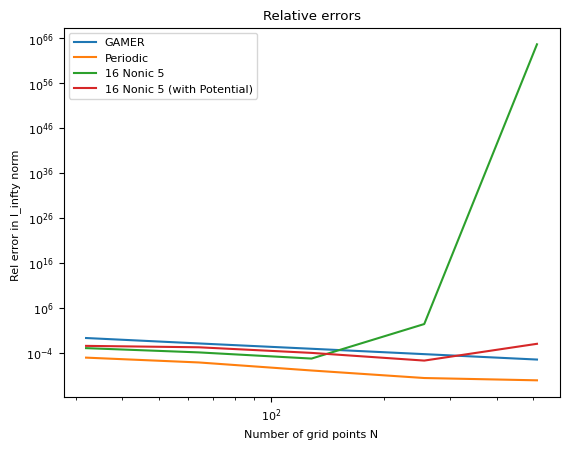

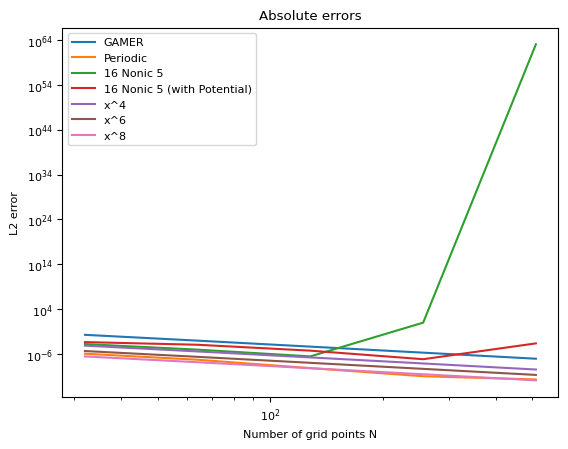

In [236]:

plt.title("Relative errors")

for i in range(len(schemes)):
    plt.loglog(resolutions, rel_errors[i], label=names[i])
plt.ylabel("Rel error in l_infty norm ")
plt.xlabel("Number of grid points N")
plt.legend()
plt.show()
plt.title("Absolute errors")

for i in range(len(schemes)):
    plt.loglog(resolutions, abs_errors[i], label=names[i])

ri = np.array(2)
plt.loglog(resolutions, abs_errors[0]/(2**(ri*4)), label = "x^4")
plt.loglog(resolutions, abs_errors[0]/(2**(ri*6)), label = "x^6")
plt.loglog(resolutions, abs_errors[0]/(2**(ri*8)), label = "x^8")
plt.ylabel("L2 error")
plt.xlabel("Number of grid points N")
plt.legend()
plt.show()


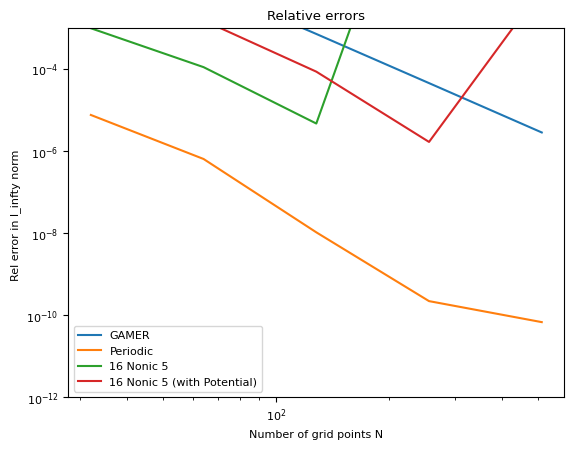

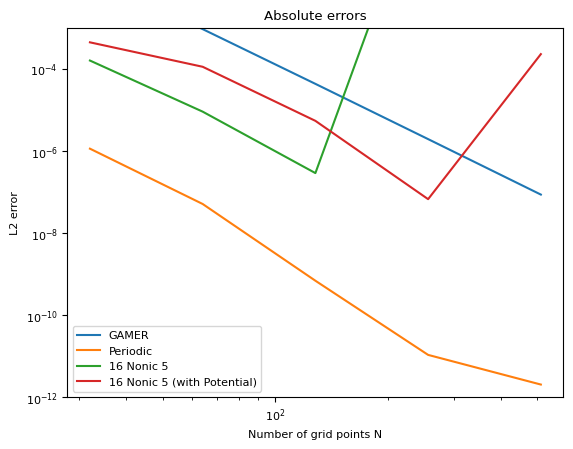

In [238]:

plt.title("Relative errors")

for i in range(len(schemes)):
    plt.loglog(resolutions, rel_errors[i], label=names[i])
plt.ylabel("Rel error in l_infty norm ")
plt.xlabel("Number of grid points N")
plt.ylim([1e-12, 1e-3])
plt.legend()
plt.show()
plt.title("Absolute errors")

for i in range(len(schemes)):
    plt.loglog(resolutions, abs_errors[i], label=names[i])
plt.ylabel("L2 error")
plt.xlabel("Number of grid points N")
plt.ylim([1e-12, 1e-3])
plt.legend()
plt.show()

Finished in 128 time steps
Finished in 512 time steps
Finished in 2048 time steps
Finished in 8192 time steps
Finished in 32768 time steps
Maximum number of timesteps reached. Aborting.
Finished in 100001 time steps


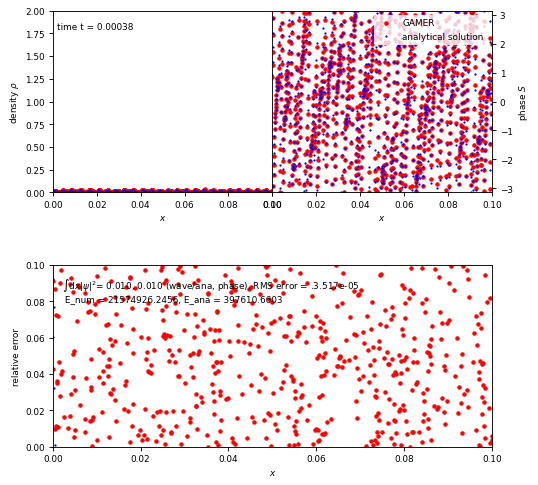

Finished in 121 time steps
Finished in 497 time steps
Finished in 2017 time steps
Finished in 8129 time steps


KeyboardInterrupt: 

In [179]:

def extraConfig(c):
    c["resolution"] = 32
    c["tEnd"] = 0.0005
    c["dpi"] = 80
    c["outputTimestep"] = False
    c["stencilOrder"] = 3
    c["timeOrder"] = 2
    c["C_parabolic"] = .4
    c["C_velocity"] = 1
    c["plotDensityLogarithm"] = False
    c["densityYlim"] = [0, 2]
    c["gravity"] = 0
    c["plotDebug"] = True
    c["xlim"] = [0, .1]
    c["domainSize"] = [0, .1]
    c["usePeriodicBC"] = False
    c["useBC"] = True
    c["boundarySize"] = 6 
    c["useAdaptiveTimestep"] = True 
    c["patchSize"] = 32
    c["replaceBoundary"] = True
    c["printGrid"] = False
    

def setSine(c_org):
    c = dict(c_org)
    c["mode"]               = FOURTH_ORDER
    c["derivativeMode"]    = MLINEAR
    c["BC"]                 = DD
    c["fd_lb"]              = 0
    c["fd_rb"]              = 0
    return c

def setCosine(c_org):
    c = dict(c_org)
    c["mode"]               = FOURTH_ORDER
    c["derivativeMode"]    = MCUBIC_NN
    c["BC"]                 = NN
    c["fd_lb"]              = 0
    c["fd_rb"]              = 0
    return c

def setPeriodic(c_org):
    c = dict(c_org)
    c["mode"]               = FOURTH_ORDER
    c["derivativeMode"]    = MNONIC_PERIODIC
    c["BC"]                 = PERIODIC
    c["fd_lb"]              = 1
    c["fd_rb"]              = 0
    return c

c = config.generateConfig()
extraConfig(c)

#Homogeneous cosine scheme
cfull = dict(c)
cfull["useBC"] = True

c16 = dict(c)
c16["useBC"] = False
c16["timeOrder"] = 1
c16["patchSize"] = 16
c16["boundarySize"] = 6

c32 = dict(c)
c32["useBC"] = False
c32["timeOrder"] = 1
c32["patchSize"] = 32
c32["boundarySize"] = 12



schemes = [wave_schemes.GAMERScheme,
           lambda c, IC:  SubregionScheme(c, IC, GAMERScheme), 
           DFTScheme, 
           DFTScheme, 
           DFTScheme, 
           lambda c, IC:  SubregionScheme(c, IC, DFTScheme),
           lambda c, IC:  SubregionScheme(c, IC, DFTScheme),
           lambda c, IC:  SubregionScheme(c, IC, DFTScheme),
           lambda c, IC:  SubregionScheme(c, IC, DFTScheme),
           lambda c, IC:  SubregionScheme(c, IC, DFTScheme),
           lambda c, IC:  SubregionScheme(c, IC, DFTScheme)      
           ]

names  = ["GAMER", 
          "GAMER (Patch size = 16)", 
          "Sine transform (whole domain)", 
          "Coine transform (whole domain)",
          "Periodic transform (whole domain)",
          "Sine (Patch size = 16)",
          "Cosine (Patch size = 16)",
          "Periodic (Patch size = 16)",
          "Sine (Patch size = 32)",
          "Cosine (Patch size = 32)",
          "Periodic (Patch size = 32)",
          ]

configs = [cfull, c16, setSine(cfull), setCosine(cfull), setPeriodic(cfull), setSine(c16), setCosine(c16), setPeriodic(c16), setSine(c32), setCosine(c32), setPeriodic(c32)]
test   = multiWave
test_name = "multiWave"
resolutions = 2**np.arange(5, 11)
rel_errors = []
abs_errors = []

for i in range(len(schemes)):
    rel_error = []
    abs_error = []
    for resolution in resolutions:
        c = configs[i]
        c["resolution"] = resolution
        scheme = (schemes[i])(c, test)
        scheme.run()
        rel_error.append(scheme.computeRelError())
        abs_error.append(scheme.computeRMSError())

        if resolution == resolutions[-1]:
            animation.drawFrame(solver = scheme, label = names[i], analyticalSolution = test)
            plt.show() 

    rel_errors.append(rel_error)
    abs_errors.append(abs_error)

plt.title("Relative errors")

for i in range(len(schemes)):
    plt.loglog(resolutions, rel_errors[i], label=names[i])
plt.ylabel("Rel error in l_infty norm ")
plt.xlabel("Number of grid points N")
plt.legend()
plt.show()
plt.title("Absolute errors")

for i in range(len(schemes)):
    plt.loglog(resolutions, abs_errors[i], label=names[i])
plt.ylabel("L2 error")
plt.xlabel("Number of grid points N")
plt.legend()
plt.show()

dx:  0.0390625
Finished in 66 time steps


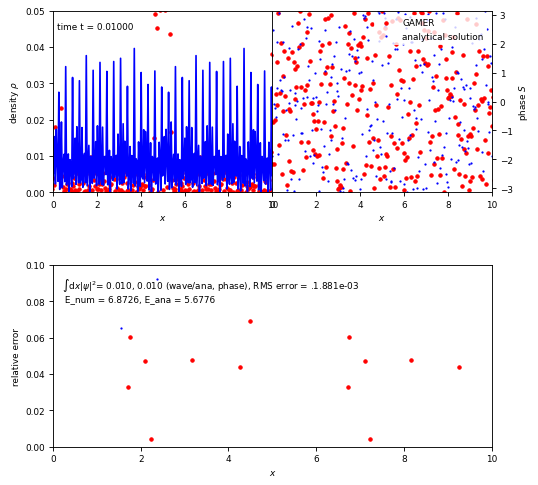

dx:  0.038910505836575876
Finished in 67 time steps


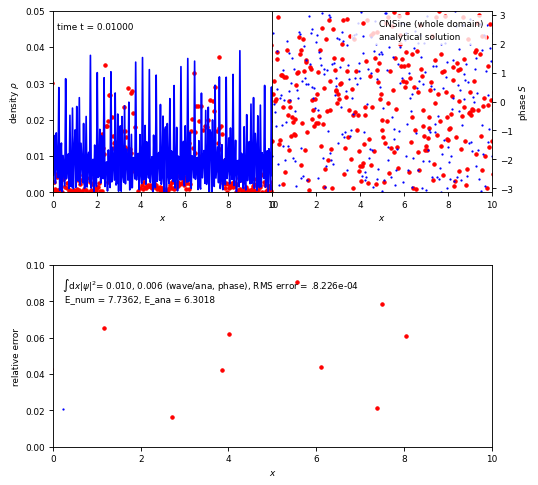

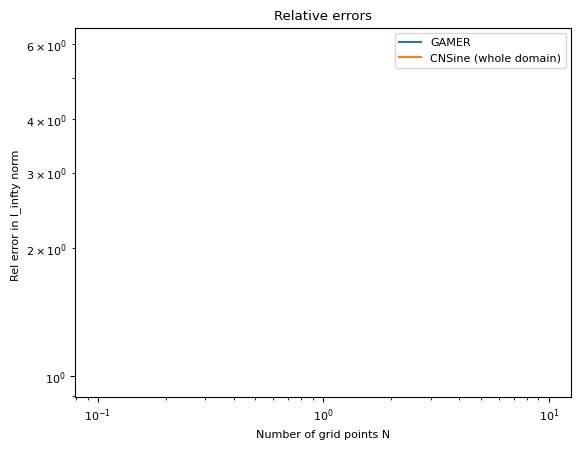

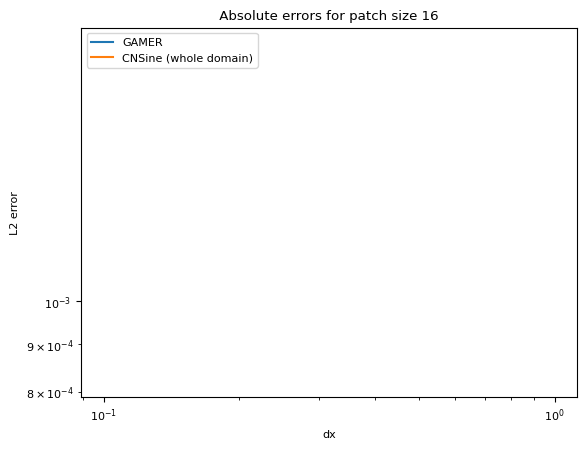

In [ ]:
boundarySize = 6
patchSize = 16

    

def extraConfig(c):
    c["resolution"] = 256
    c["tEnd"] = 0.01
    c["dpi"] = 80
    c["outputTimestep"] = False
    c["stencilOrder"] = 3
    c["timeOrder"] = 2
    c["C_parabolic"] = .1
    c["C_velocity"] = 1
    c["plotDensityLogarithm"] = False
    c["densityYlim"] = [0, 0.05]
    c["gravity"] = 0
    c["plotDebug"] = True
    c["xlim"] = [0, .1]
    c["domainSize"] = [0, .1]
    c["usePeriodicBC"] = False 
    c["useBC"] = False
    c["boundarySize"] = boundarySize
    c["useAdaptiveTimestep"] = True 
    c["patchSize"] = patchSize
    c["printGrid"] = False
    
c = config.generateConfig()
extraConfig(c)

c1 = dict(c)
c2 = dict(c)
c2["useBC"] = True

schemes = [wave_schemes.GAMERScheme, HomogeneousSineScheme]
names  = ["GAMER", "CNSine (whole domain)", "Sine transform (whole domain)"]
configs = [c1, c2]
test   = multiWave
test_name = "Periodic 1D Gaussian"
resolutions = 2**np.arange(0, 1)
rel_errors = []
abs_errors = []

half_width = 5

for i in range(len(schemes)):
    rel_error = []
    abs_error = []
    for resolution in resolutions:
        c = configs[i]
        c["domainSize"] = [5 - half_width/resolution, 5 + half_width/resolution]
        scheme = (schemes[i])(c, test)
        scheme.run()
        rel_error.append(scheme.computeRelError())
        abs_error.append(scheme.computeRMSError())
        animation.drawFrame(solver = scheme, label = names[i], analyticalSolution = test)
        plt.savefig(f"{resolution}_{names[i]}.png")
        plt.show() 

    rel_errors.append(rel_error)
    abs_errors.append(abs_error)

plt.title("Relative errors")

for i in range(len(schemes)):
    plt.loglog(resolutions, rel_errors[i], label=names[i])
plt.ylabel("Rel error in l_infty norm ")
plt.xlabel("Number of grid points N")
plt.legend()
plt.show()
plt.title(f" Absolute errors for patch size {patchSize} ")

for i in range(len(schemes)):
    plt.loglog((10/resolutions)/patchSize, abs_errors[i], label=names[i])
plt.ylabel("L2 error")
plt.xlabel("dx")
plt.legend()
plt.show()